In [3]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial
import imageio
from scipy.fft import fft
from scipy.signal import coherence

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

In [4]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/PPR_GABAzine/"
catalog_csv = data_dir + 'ppr_catalog_backup.csv'
export_csv = data_dir + 'export_summary_backup.csv'

In [5]:
# load csv files
catalog_df = pd.read_csv(catalog_csv)
catalog_df = pd.DataFrame(catalog_df)
catalog_df

zda_file  pulse1_start  \
0   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
1   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
5   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   
6   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
7   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
8   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
9   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
10  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
11  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
12  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
13  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
14  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   
15  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   
16  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
17  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
18  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   
19  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   
20  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
21  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
22  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
23  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   
24  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
25  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           216   
26  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
27  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           316   
28  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...           116   

    pulse1_width  pulse2_start  pulse2_width  baseline_start  baseline_width  \
0             37         356.0          37.0             216             340   
1             37           NaN           NaN             216             200   
2             37         356.0          37.0             116             440   
3             37           NaN           NaN             316             200   
4             37         356.0          37.0             316             240   
5             37         356.0          37.0             116             440   
6             37         356.0          37.0             316             240   
7             37           NaN           NaN             316             200   
8             37           NaN           NaN             216             200   
9             37         356.0          37.0             216             340   
10            37         356.0          37.0             316             240   
11            37           NaN           NaN             316             200   
12            37         356.0          37.0             216             340   
13            37         356.0          37.0             316             240   
14            37           NaN           NaN             116             200   
15            37         356.0          37.0             116             440   
16            37           NaN           NaN             316             200   
17            37           NaN           NaN             216             200   
18            37         356.0          37.0             116             440   
19            37           NaN           NaN             116             200   
20            37         356.0          37.0             316             240   
21            37           NaN           NaN             316             200   
22            37         356.0          37.0             216             3

In [6]:
export_df = pd.read_csv(export_csv)
export_df = pd.DataFrame(export_df)
export_df  # home barrels are ROI 1, neighbor barrels are ROI 2

ROI       amp        snr   latency  halfwidth  Stim_Distance  ROI_Set  \
0     1  3.240620   82.56380  111.3310    7.02716            NaN  _pulse1   
1     2  2.764110   68.33530  112.0980    8.34659            NaN  _pulse1   
2     1  0.091519    2.33170  435.9430   13.82040            NaN  _pulse2   
3     2  0.072115    1.78285  435.8300   13.92020            NaN  _pulse2   
4     1  3.430300  154.39000  111.3560    7.36080            NaN  _pulse1   
..  ...       ...        ...       ...        ...            ...      ...   
85    2  0.955407    6.44764  434.9500   14.80010            NaN  _pulse2   
86    1  7.449480   52.96870  162.9420 -325.80000            NaN  _pulse1   
87    2  7.283500   55.21390  164.3210 -328.55700            NaN  _pulse1   
88    1  6.819580  369.38800   62.9036 -125.68400            NaN  _pulse1   
89    2  5.347110   15.01450   64.8849 -129.64500            NaN  _pulse1   

         Date  Slice  Location  Recording  \
0   9/16/2024      2         1          1   
1   9/16/2024      2         1          1   
2   9/16/2024      2         1          1   
3   9/16/2024      2         1          1   
4   9/16/2024      2         1          2   
..        ...    ...       ...        ...   
85  9/20/2024      2         2          6   
86  9/20/2024      2         2          8   
87  9/20/2024      2         2          8   
88  9/20/2024      2         2          9   
89  9/20/2024      2         2          9   

                                                trace  \
0   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
1   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
..                                                ...   
85  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
86  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
87  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
88  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
89  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   

                                    trace_non_polyfit  \
0   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
1   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
..                                                ...   
85  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
86  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
87  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
88  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
89  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   

                                            amp_array  
0   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
1   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
..                                                ...  
85  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
86  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
87  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
88  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  
89  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  

[90 rows x 14 columns]

In [7]:
# first, look up metadata in catalog_df and append to export_df
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

def format_date(date, input_format="%m/%d/%Y", format="%m-%d-%y"):
    date = datetime.datetime.strptime(date, input_format)
    return date.strftime(format)

def format_zda(slic, loc, rec):
    """ pad to ss_ll_rr """
    slic = str(slic).zfill(2)
    loc = str(loc).zfill(2)
    rec = str(rec).zfill(2)
    return slic + '_' + loc + '_' + rec

append_columns = {'ipi': [], 'drug' : [], 'num_pulses': [] }
for index, row in export_df.iterrows():
    date = row['Date']    
    slic = row['Slice']
    location = row['Location']
    recording = row['Recording']
    file_formatted_date = format_date(date)
    zda_id = format_zda(row['Slice'], row['Location'], row['Recording'])

    # look up zda file in catalog
    zda_row = catalog_df.loc[(catalog_df['zda_file'].str.contains(file_formatted_date)) &
                              (catalog_df['zda_file'].str.contains(zda_id))]

    append_columns['ipi'].append(zda_row['IPI'].values[0])
    drug, num_pulses = zda_row['Notes'].values[0].split(',')
    append_columns['drug'].append(drug)
    append_columns['num_pulses'].append(num_pulses)

# append columns to export_df
for key, value in append_columns.items():
    export_df[key] = value
export_df

ROI       amp        snr   latency  halfwidth  Stim_Distance  ROI_Set  \
0     1  3.240620   82.56380  111.3310    7.02716            NaN  _pulse1   
1     2  2.764110   68.33530  112.0980    8.34659            NaN  _pulse1   
2     1  0.091519    2.33170  435.9430   13.82040            NaN  _pulse2   
3     2  0.072115    1.78285  435.8300   13.92020            NaN  _pulse2   
4     1  3.430300  154.39000  111.3560    7.36080            NaN  _pulse1   
..  ...       ...        ...       ...        ...            ...      ...   
85    2  0.955407    6.44764  434.9500   14.80010            NaN  _pulse2   
86    1  7.449480   52.96870  162.9420 -325.80000            NaN  _pulse1   
87    2  7.283500   55.21390  164.3210 -328.55700            NaN  _pulse1   
88    1  6.819580  369.38800   62.9036 -125.68400            NaN  _pulse1   
89    2  5.347110   15.01450   64.8849 -129.64500            NaN  _pulse1   

         Date  Slice  Location  Recording  \
0   9/16/2024      2         1          1   
1   9/16/2024      2         1          1   
2   9/16/2024      2         1          1   
3   9/16/2024      2         1          1   
4   9/16/2024      2         1          2   
..        ...    ...       ...        ...   
85  9/20/2024      2         2          6   
86  9/20/2024      2         2          8   
87  9/20/2024      2         2          8   
88  9/20/2024      2         2          9   
89  9/20/2024      2         2          9   

                                                trace  \
0   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
1   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
..                                                ...   
85  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
86  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
87  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
88  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
89  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   

                                    trace_non_polyfit  \
0   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
1   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
..                                                ...   
85  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
86  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
87  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
88  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
89  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   

                                            amp_array  ipi      drug  \
0   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   70      ACSF   
1   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   70      ACSF   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   70      ACSF   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   70      ACSF   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   70      ACSF   
..                                                ...  ...       ...   
85  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   20  Gabazine   
86  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   20  Gabazine   
87  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   20  Gabazine   
88  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  120  Gabazine   
89  C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...  120  Gabazine   

   num_pulses  
0         PPR  
1         PPR  
2         PPR  
3         PPR  
4     control  
..        ...  
85        PPR  
86    Control  
87    Control  
88    Control  
89    Control  

[90 rows x 17 columns]

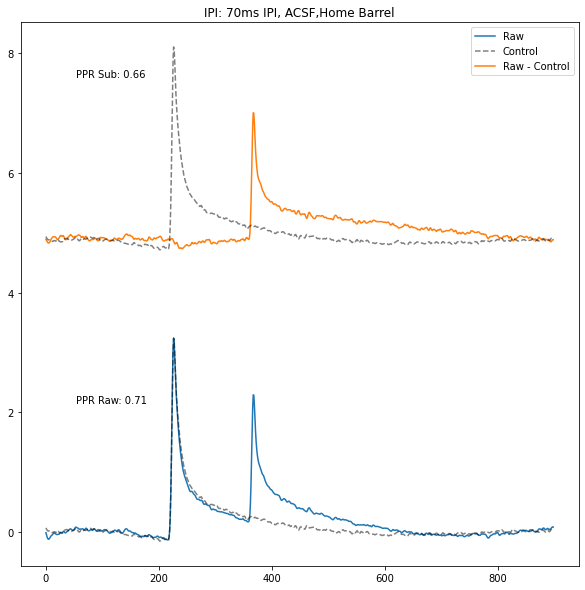

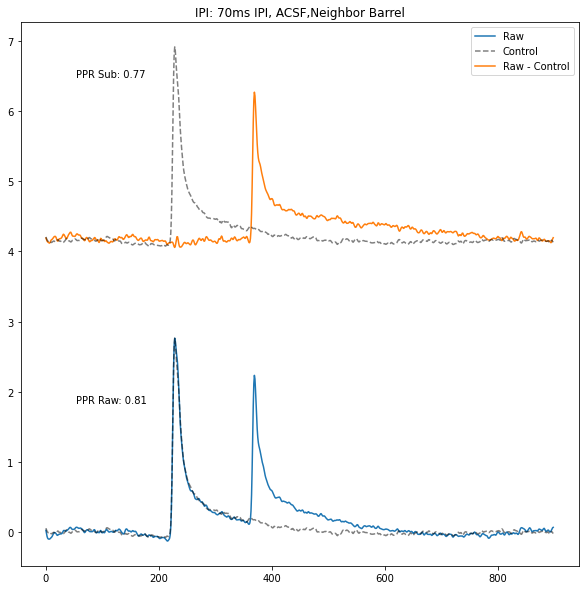

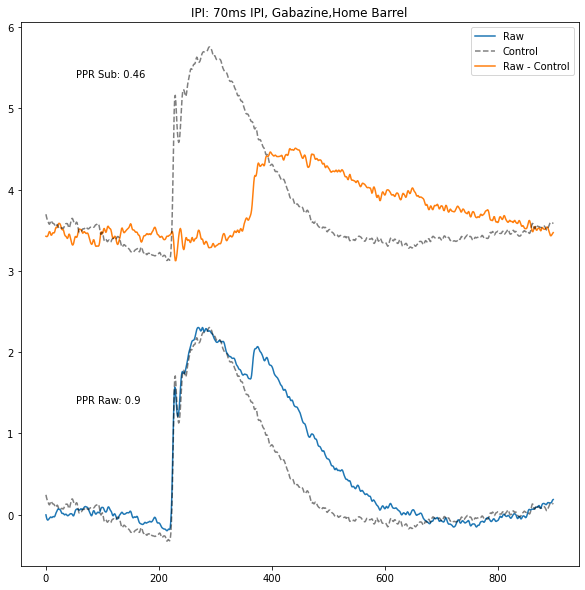

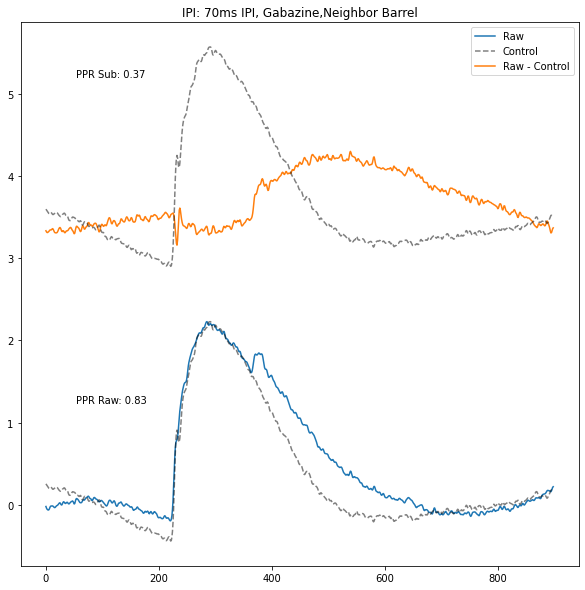

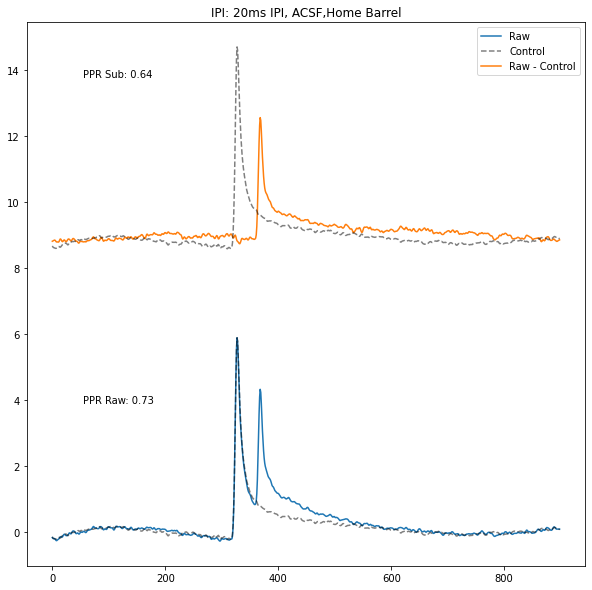

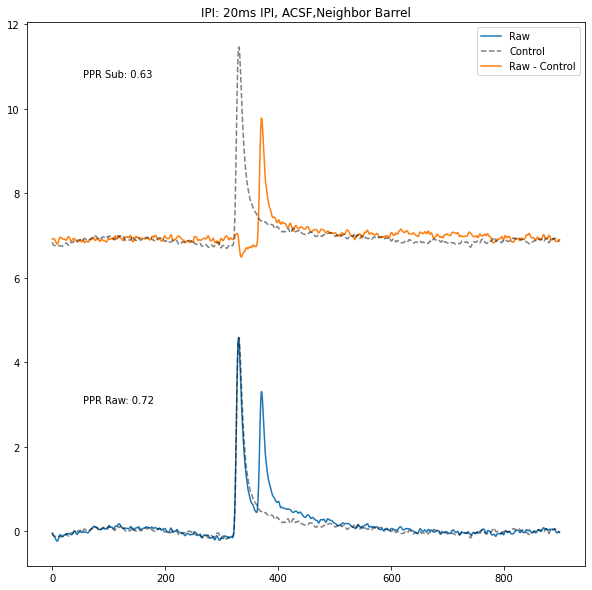

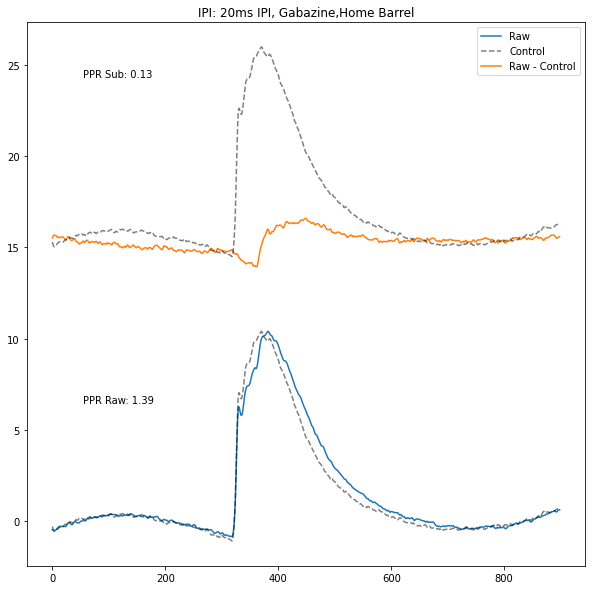

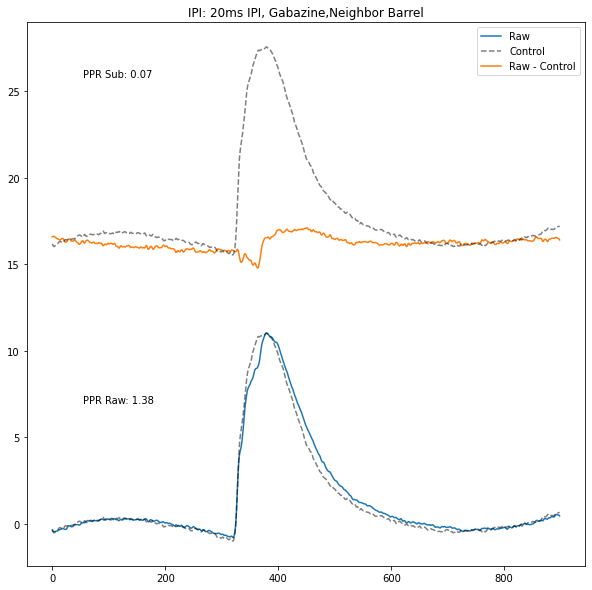

In [9]:
# for each ROI, load traces and perform summation decomposition by 
# subtracting the control trace from the paired-pulse trace.
# display the traces and the maxAmp arrays for each pulse
ppr = {}

for ipi in export_df['ipi'].unique():
    ipi_df = export_df[export_df['ipi'] == ipi]
    for drug in ipi_df['drug'].unique():
        drug_df = ipi_df[ipi_df['drug'] == drug]
        for roi in drug_df['ROI'].unique():
            roi_df = drug_df[drug_df['ROI'] == roi]
            roi_idx = 'ROI' + str(roi)
            
            ppr_row = roi_df[roi_df['num_pulses'].str.contains('PPR')]
            control_row = roi_df[roi_df['num_pulses'].str.contains('ontrol')]

            # load traces
            if ppr_row.empty or control_row.empty:
                continue
            ppr_trace = read_dat_trace_file(ppr_row['trace'].values[0])
            ppr_trace_non_polyfit = read_dat_trace_file(ppr_row['trace_non_polyfit'].values[0])
            control_trace = read_dat_trace_file(control_row['trace'].values[0])
            control_trace_non_polyfit = read_dat_trace_file(control_row['trace_non_polyfit'].values[0])

            # normalize the control traces to the max amp of the ppr traces
            control_trace_non_polyfit = control_trace_non_polyfit * (ppr_trace_non_polyfit.max() / control_trace_non_polyfit.max())
            control_trace = control_trace * (ppr_trace.max() / control_trace.max())

            trace_sub = ppr_trace_non_polyfit[roi_idx] - control_trace_non_polyfit[roi_idx]

            # calculate dist from zero of subtracted trace before second stim
            trace_sub_dist = trace_sub[(trace_sub.index < 356) | (trace_sub.index > 550)].abs().mean()
            if trace_sub_dist > 1:
                print('Warning: trace_sub_dist is greater than 1: ' + str(trace_sub_dist))
                continue

            # calculate maxAmp of subtracted trace in measure window (356 - 450)
            trace_sub_max = trace_sub[(trace_sub.index > 356) & (trace_sub.index < 450)].max()

            # calculate first and second maxAmp of raw trace in measure windows
            second_pulse_measure_window = [356, 450]
            first_pulse_measure_window = [116, 350]

            pulse1_raw_maxamp = ppr_trace[(ppr_trace.index > first_pulse_measure_window[0]) & 
                                          (ppr_trace.index < first_pulse_measure_window[1])][roi_idx].max()
            pulse2_raw_maxamp = ppr_trace[(ppr_trace.index > second_pulse_measure_window[0]) &
                                          (ppr_trace.index < second_pulse_measure_window[1])][roi_idx].max()

            ppr_raw = pulse2_raw_maxamp / pulse1_raw_maxamp
            ppr_sub = trace_sub_max / pulse1_raw_maxamp

            # show both traces and their subtraction (PPR - Control)
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            roi_idx = 'ROI' + str(roi)
            ax.plot(ppr_trace['Pt'], ppr_trace[roi_idx], label='Raw')
            ax.plot(control_trace['Pt'], control_trace[roi_idx], 'k--', label='Control', alpha=0.5)
            ax.plot(ppr_trace['Pt'], 
                        trace_sub + np.max(control_trace[roi_idx]) * 1.5, 
                        label='Raw - Control')
            ax.plot(ppr_trace['Pt'], 
                        control_trace[roi_idx] + np.max(control_trace[roi_idx]) * 1.5, 'k--', 
                        alpha=0.5)
            ax.legend()
            # annotate with ppr_raw, ppr_sub, and trace_sub_dist
            ax.text(0.1, 0.3, 'PPR Raw: ' + str(round(ppr_raw,2)), transform=ax.transAxes)
            ax.text(0.1, 0.9, 'PPR Sub: ' + str(round(ppr_sub,2)), transform=ax.transAxes)
            ax.set_title('IPI: ' + str(ipi) + 'ms IPI, ' + drug + ',' + ("Home" if roi == 1 else "Neighbor") + " Barrel")
            #ax.text(0.1, 0.7, 'Trace Sub Dist: ' + str(trace_sub_dist)[:6], transform=ax.transAxes)
            plt.show()

            if ipi not in ppr:
                ppr[ipi] = {}
            if drug not in ppr[ipi]:
                ppr[ipi][drug] = {}
            if roi not in ppr[ipi][drug]:
                ppr[ipi][drug][roi] = {}
            ppr[ipi][drug][roi]['ppr_raw'] = ppr_raw
            ppr[ipi][drug][roi]['ppr_sub'] = ppr_sub

[14.721534432296664, 11.857249693956533, 39.539347287956076, 26.6357272876229, 12.705252820685388, 12.846145375147273]
ACSF ROI1 19.717542816277472 4.56032831570596
[16.188342100129944, 13.484685449883557, 29.689147619567365, 18.569399587290775, 69.16185830196233, 63.278912209406826]
ACSF ROI2 35.062057544706796 10.13519173904902
[116.07476578470363, 139.46701978328423, 156.36427946904092, 145.74493356513392, 145.8294619317751, 140.85022051866162, 153.46639123543656]
Gabazine ROI1 142.54243889829084 4.98640062418892
[107.97207937532289, 140.8982244518159, 162.94333979925534, 162.703831572659, 145.6575361525644, 139.69752430695831, 132.92101925959338]
Gabazine ROI2 141.82765070259558 7.116855146630082


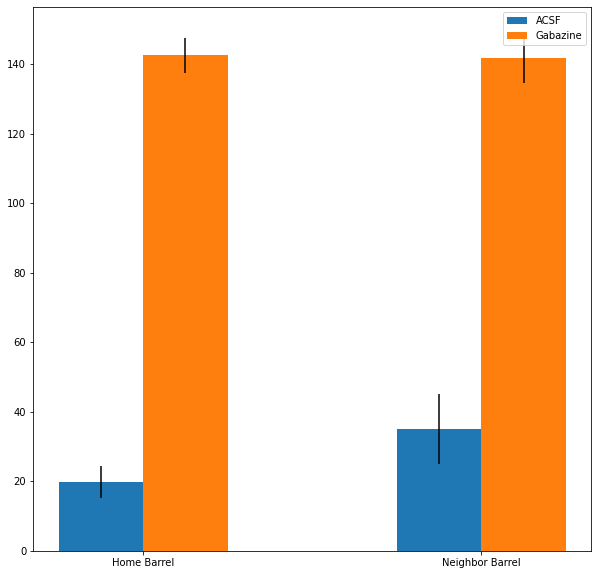

In [101]:
# compare control halfwidth ACSF versus GABAzine
# average over IPIs but compare Home versus Neighbor barrels and ACSF versus GABAzine

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
handles = []
for drug in export_df['drug'].unique():
    drug_df = export_df[export_df['drug'] == drug]
    roi_df = drug_df[drug_df['ROI'] == 1]

    control_df = roi_df[roi_df['num_pulses'].str.contains('ontrol')]
    for roi in ['ROI1', 'ROI2']:
    

        halfwidths = []
        for _, control_row in control_df.iterrows():
        
            # get the trace and calculate halfwidth
            control_trace = read_dat_trace_file(control_row['trace'])[roi]

            # calculate maxAmp and its Pt index
            max_amp = control_trace.max()
            max_amp_idx = control_trace.idxmax()

            # calculate halfwidth (time from rising halfamp to falling halfamp)
            half_width = [0, 0]
            for i in range(max_amp_idx, len(control_trace)):
                if control_trace[i] < max_amp / 2:
                    # interpolate to get the exact time
                    half_width[0] = i + (control_trace[i] - max_amp / 2) / (control_trace[i] - control_trace[i - 1])
                    break

            for i in range(max_amp_idx, 0, -1):
                if control_trace[i] < max_amp / 2:
                    # interpolate to get the exact time
                    half_width[1] = i + (control_trace[i] - max_amp / 2) / (control_trace[i] - control_trace[i + 1])
                    break

            halfwidth = half_width[0] - half_width[1]
            halfwidths.append(halfwidth)
        print(halfwidths)
        i_plot_loc = int(roi[-1])
        i_plot_loc += (0.125 if drug == 'Gabazine' else -0.125)
        l1 = ax.bar(i_plot_loc, np.mean(halfwidths), yerr=sem(halfwidths),
                    label=drug, color= "tab:orange" if drug == 'Gabazine' else "tab:blue",
                    width=0.25)
        print(drug, roi, np.mean(halfwidths), sem(halfwidths))
        handles.append(l1)
# set ticks
ax.set_xticks([1, 2])
ax.set_xticklabels(['Home Barrel', 'Neighbor Barrel'])
ax.legend(handles=[handles[0], handles[-1]], labels=['ACSF', 'Gabazine'])
plt.show()
        


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.tr

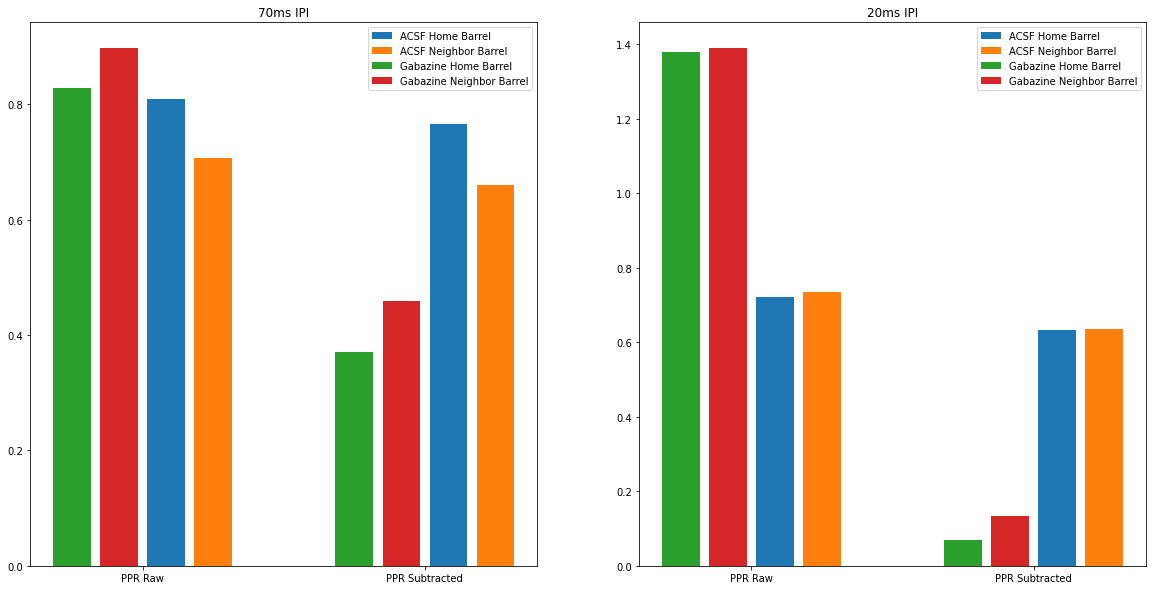

In [75]:
# plot ppr_raw and ppr_sub for each IPI on bar graphs
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
i_plot = -1
base_spacing_sub_vs_raw = 3
for ipi in ppr.keys():
    i_plot += 1
    for drug in ppr[ipi].keys():
        i_drug_shift = -1 if drug == 'Gabazine' else 1
        ppr_raw = []
        ppr_sub = []
        for roi in ppr[ipi][drug].keys():
            ax[i_plot].bar([ipi - base_spacing_sub_vs_raw + roi + i_drug_shift, ipi + base_spacing_sub_vs_raw + roi + i_drug_shift], 
                [ppr[ipi][drug][roi]['ppr_raw'], ppr[ipi][drug][roi]['ppr_sub']], 
                yerr=[sem(ppr_raw), sem(ppr_sub)], 
                label=drug + ' ' + ("Home" if roi == 1 else "Neighbor") + " Barrel")
    ax[i_plot].legend()
    ax[i_plot].set_title(str(ipi) + 'ms IPI')

    # label the x-ticks with PPR Raw and PPR Subtracted
    ax[i_plot].set_xticks([ipi - base_spacing_sub_vs_raw + 1.5, ipi + base_spacing_sub_vs_raw + 1.5])
    ax[i_plot].set_xticklabels(['PPR Raw', 'PPR Subtracted'])
plt.show()

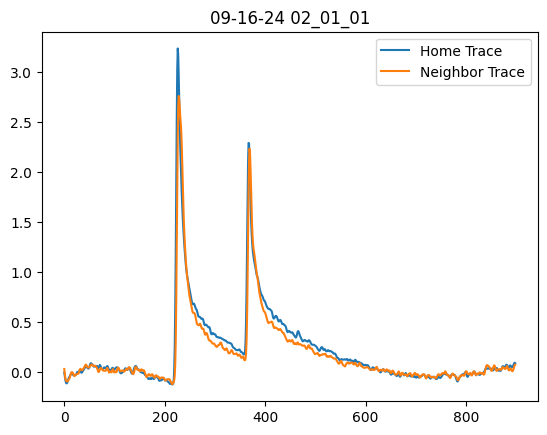

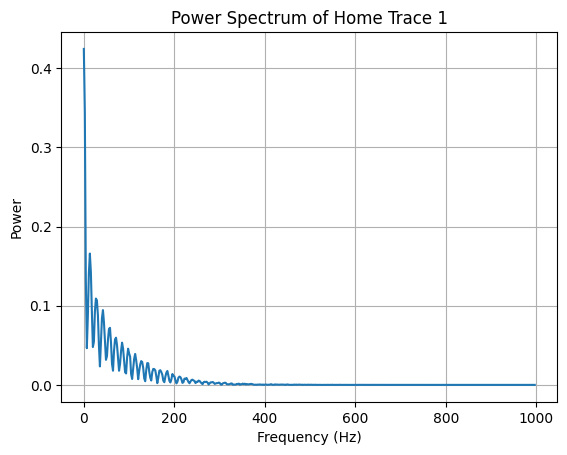

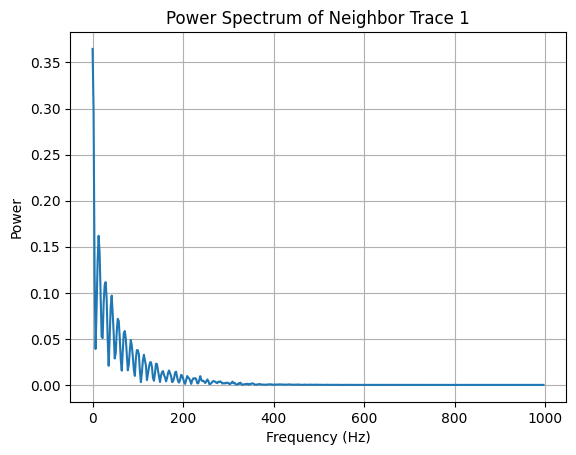

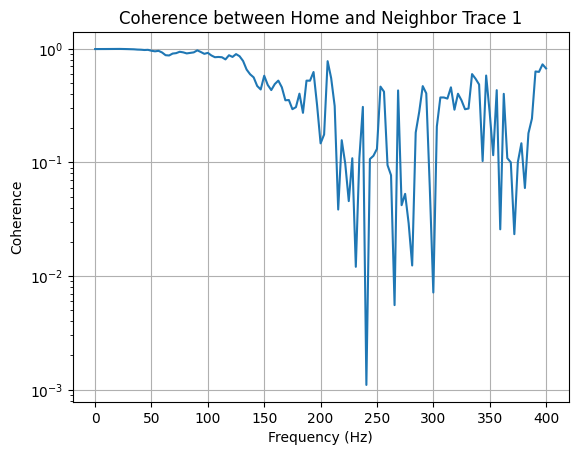

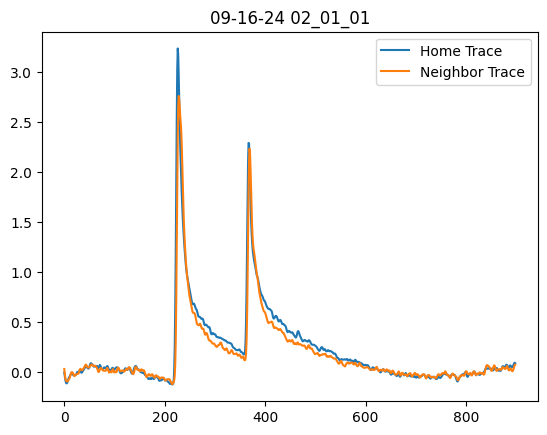

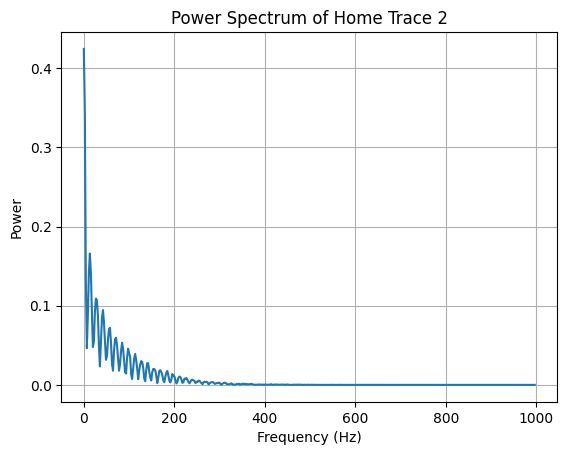

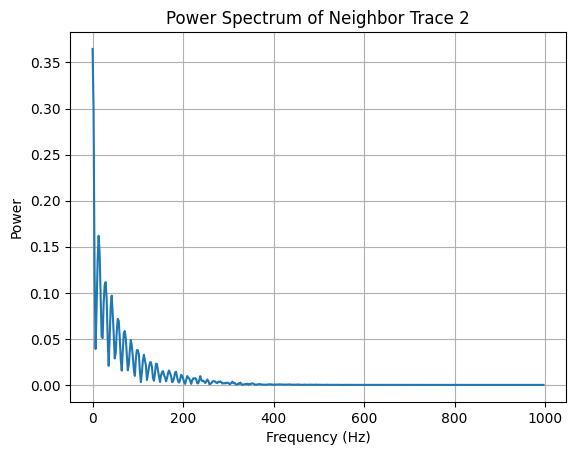

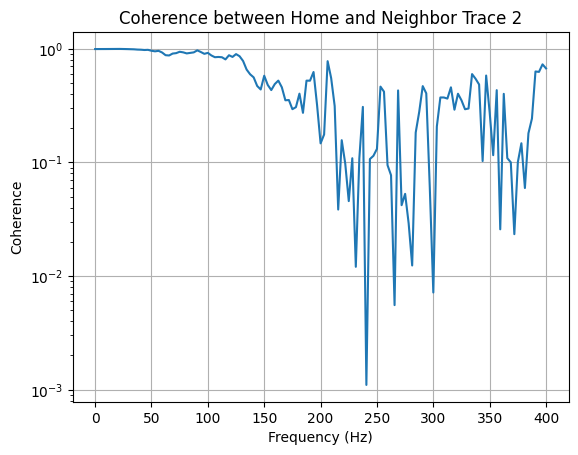

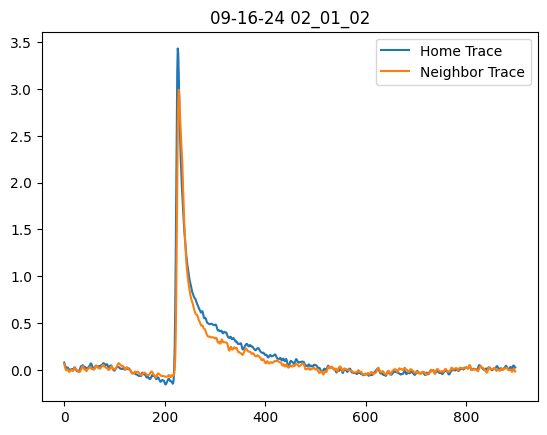

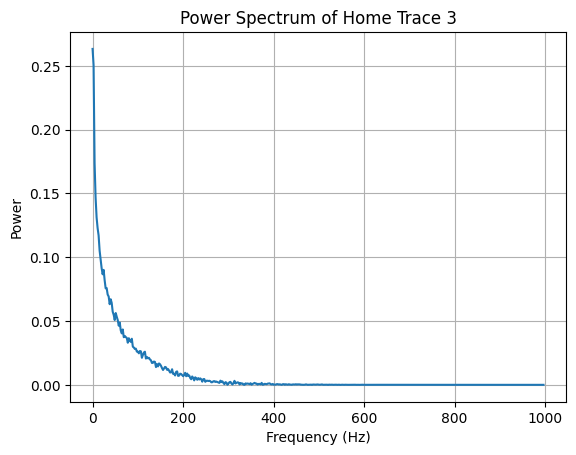

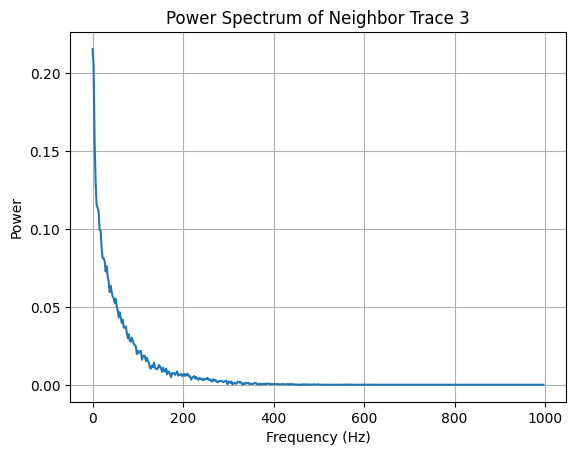

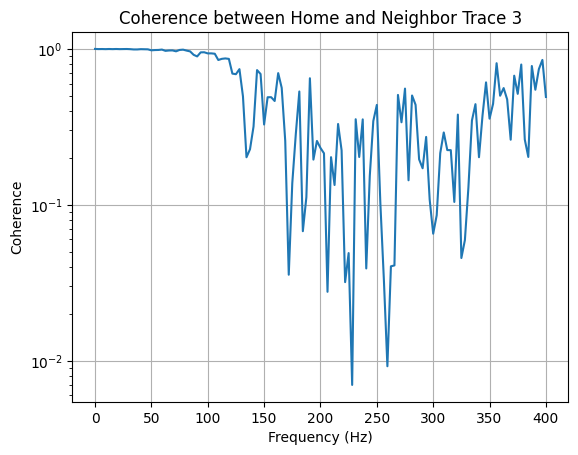

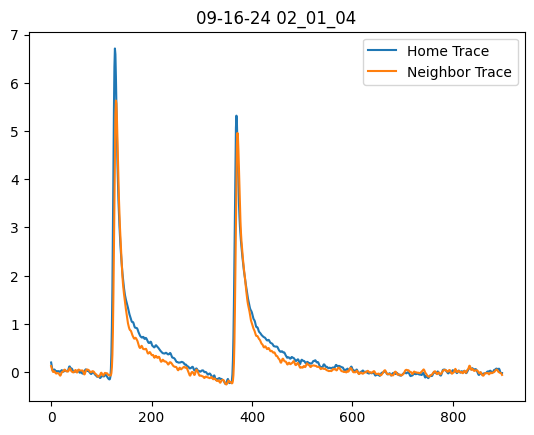

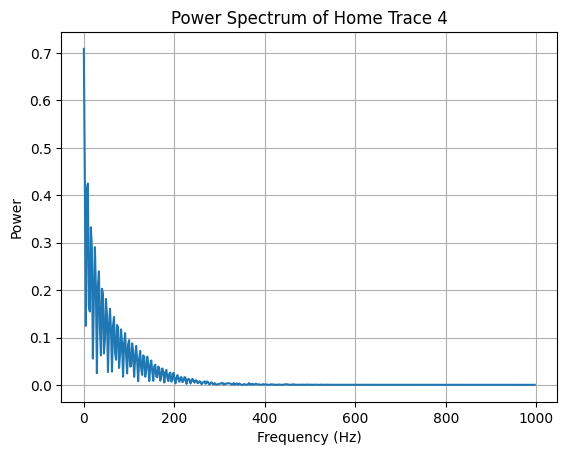

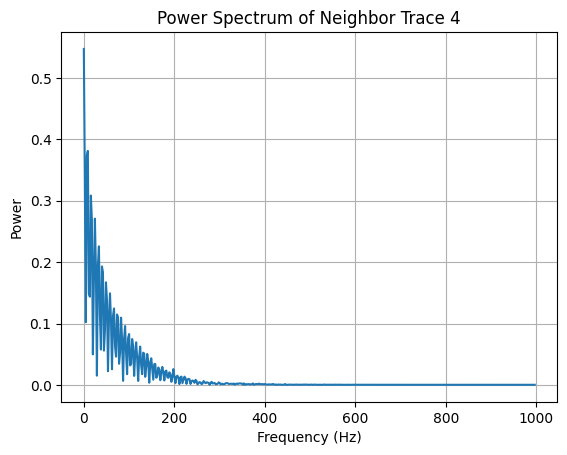

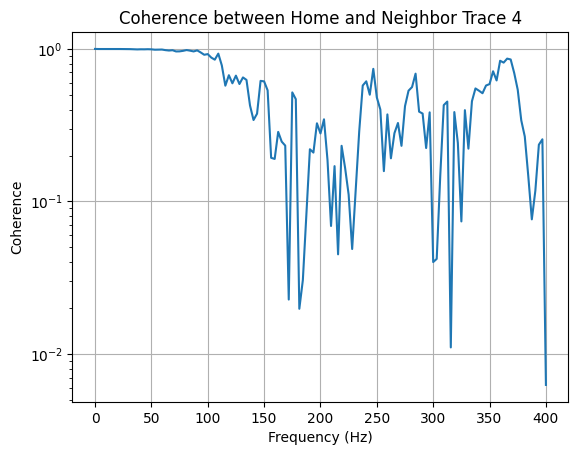

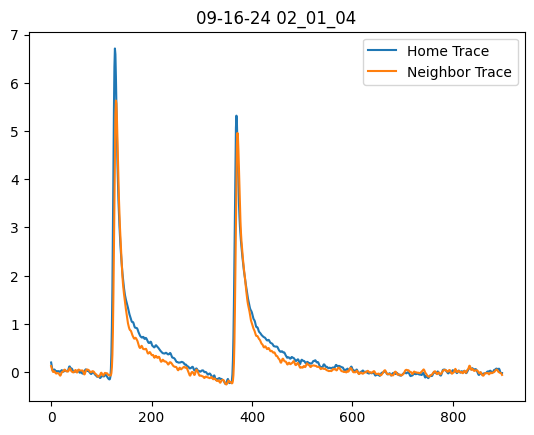

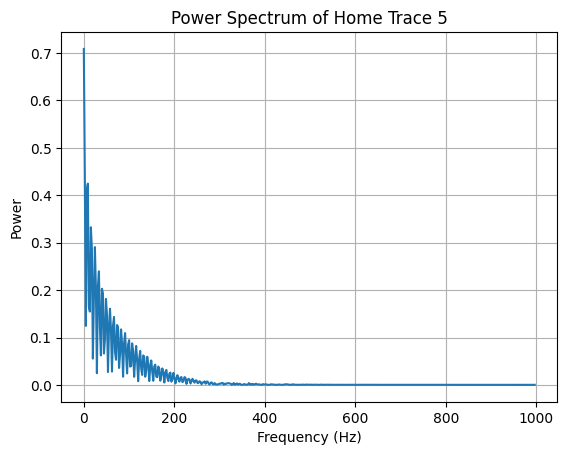

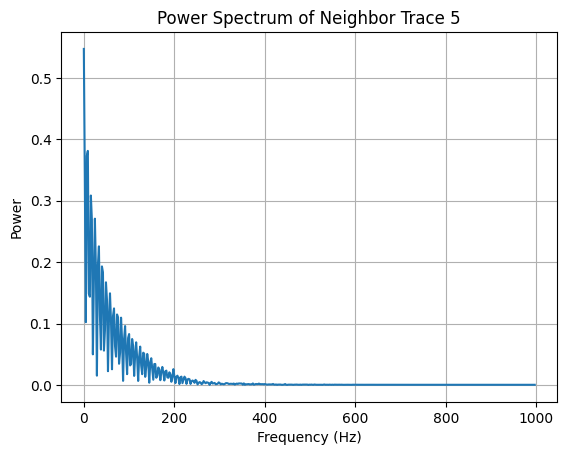

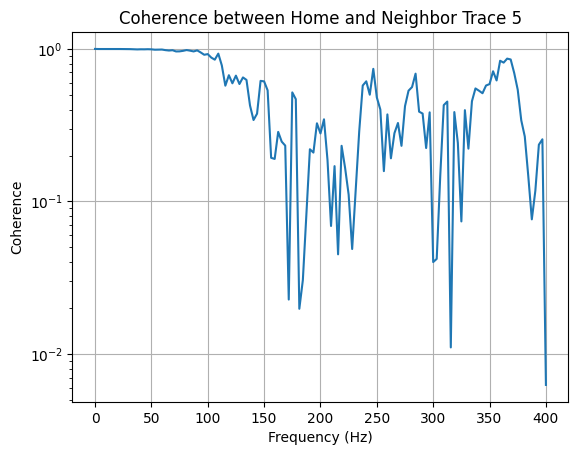

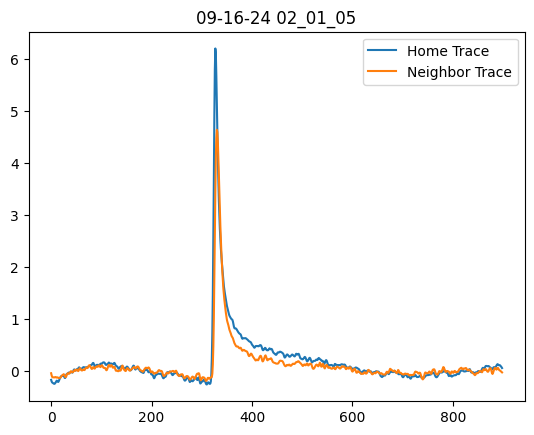

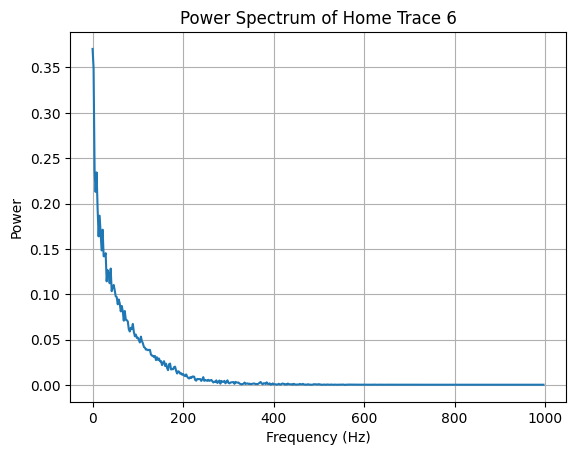

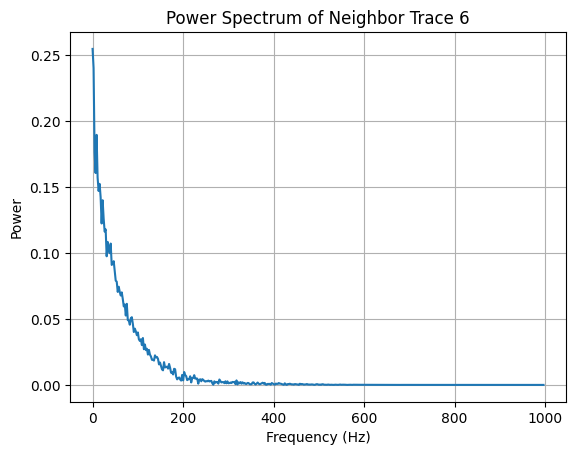

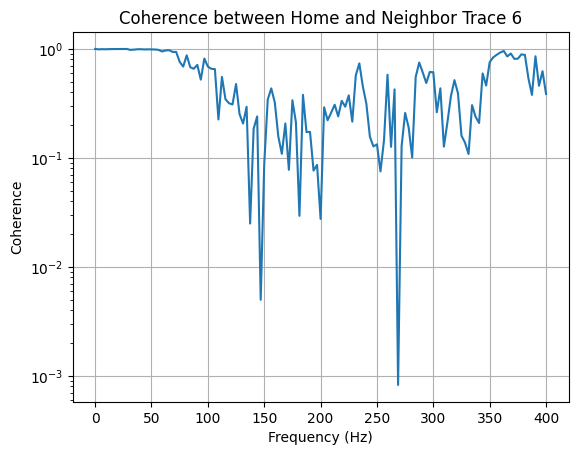

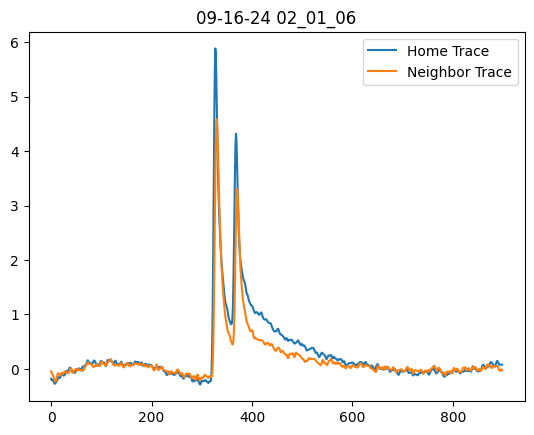

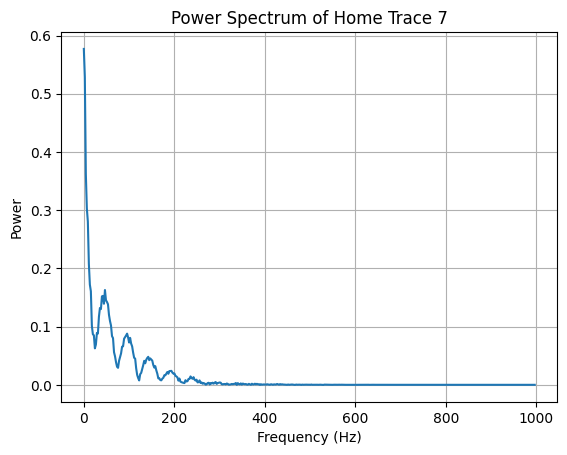

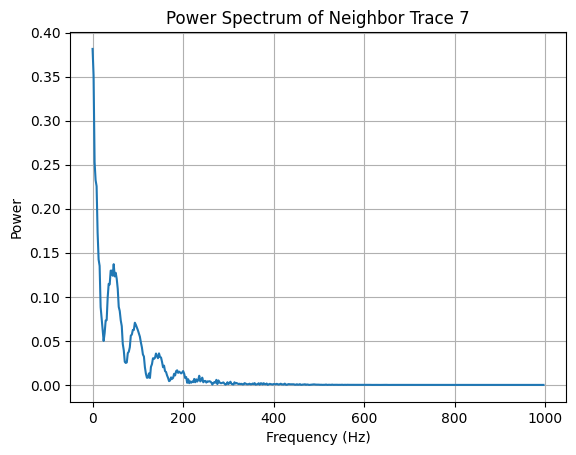

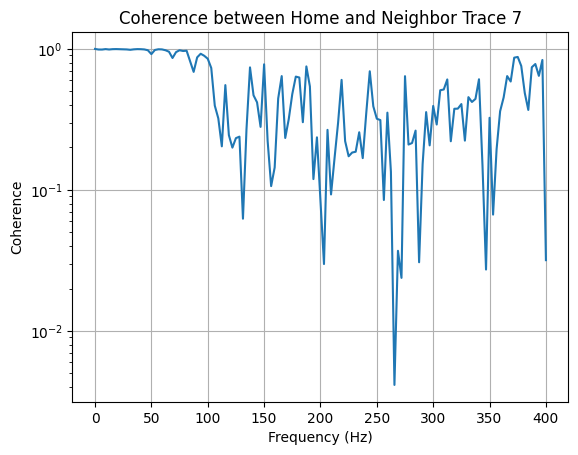

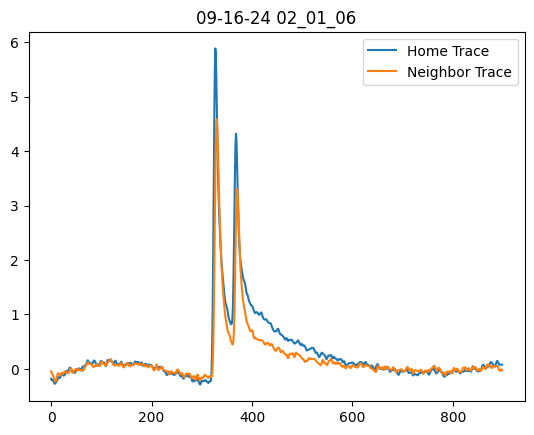

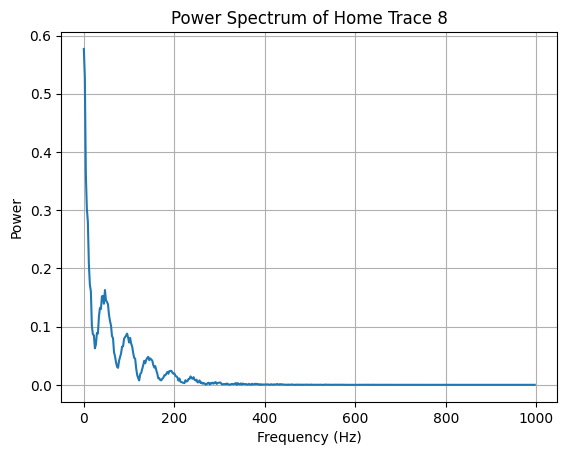

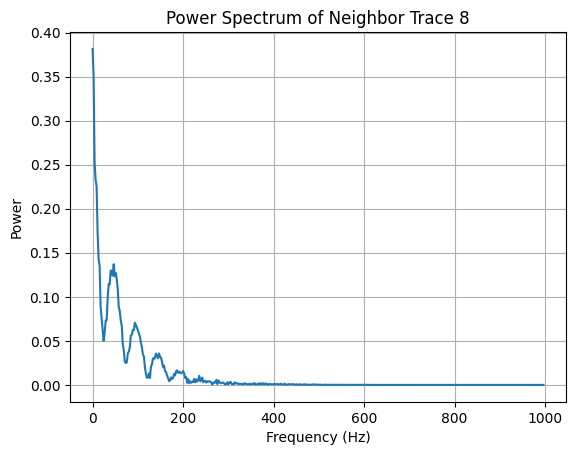

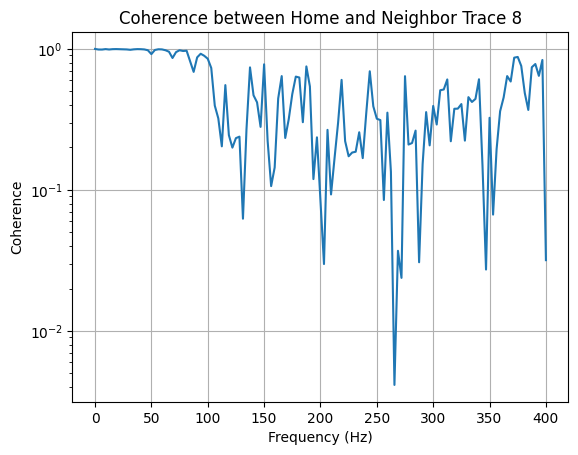

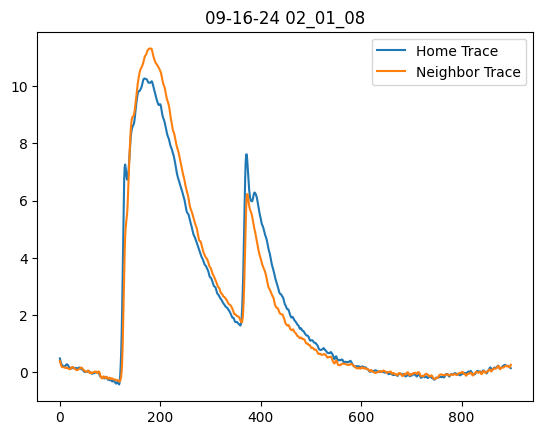

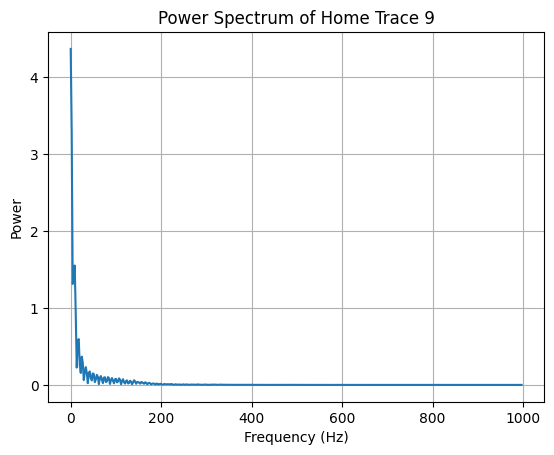

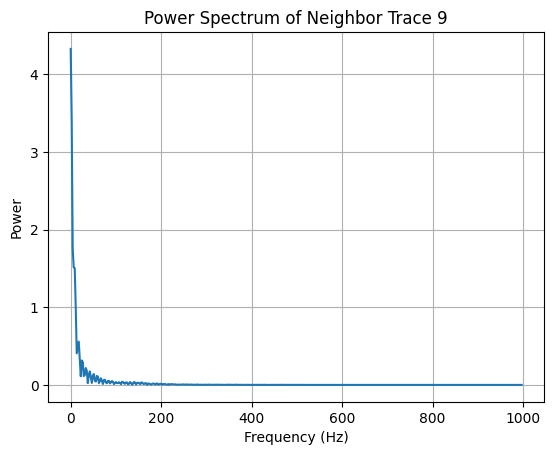

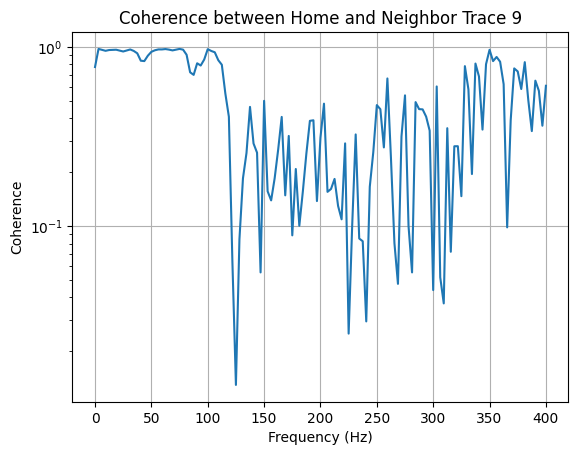

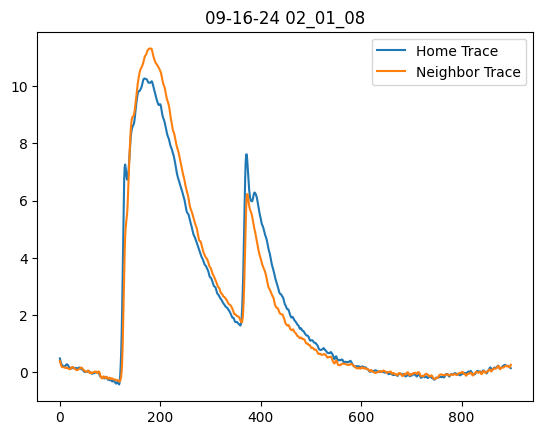

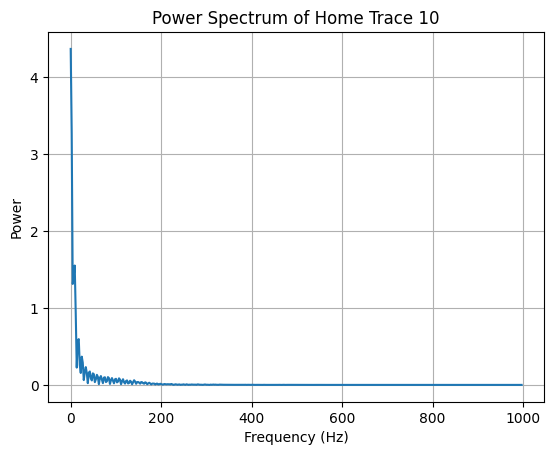

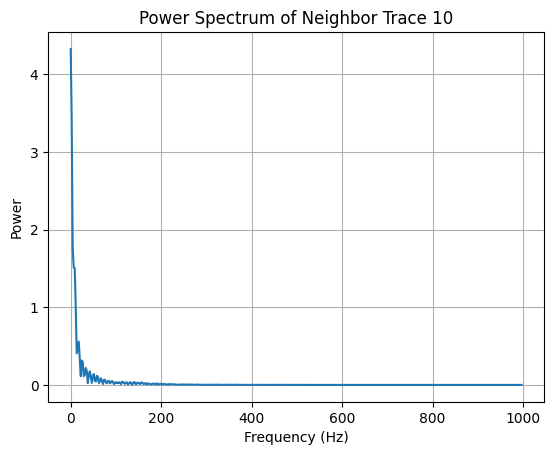

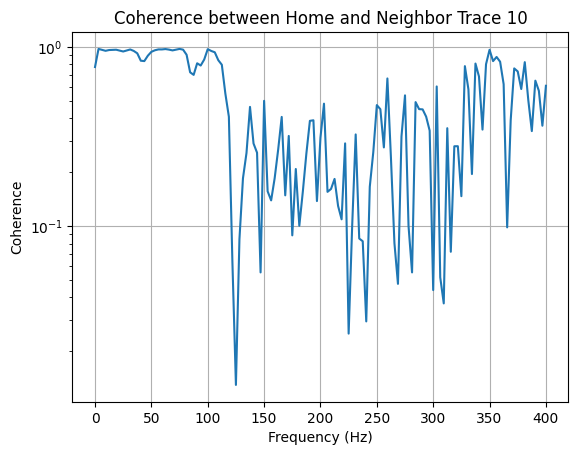

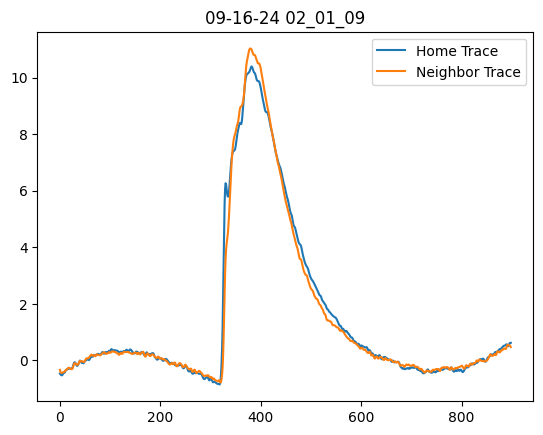

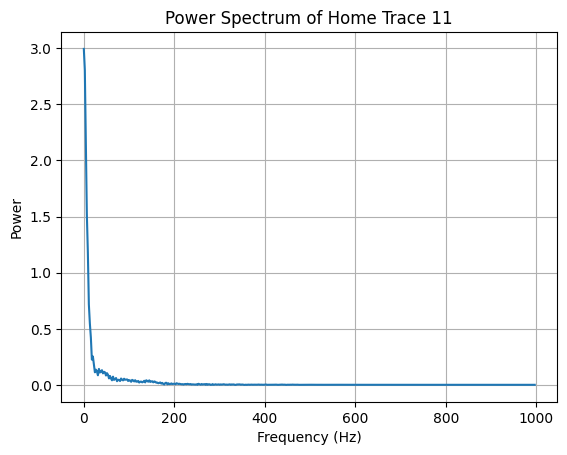

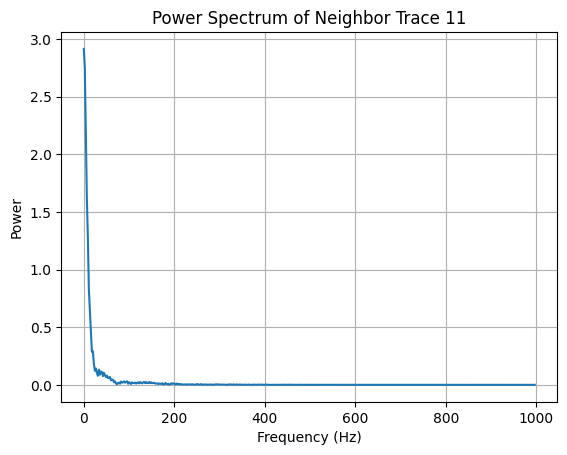

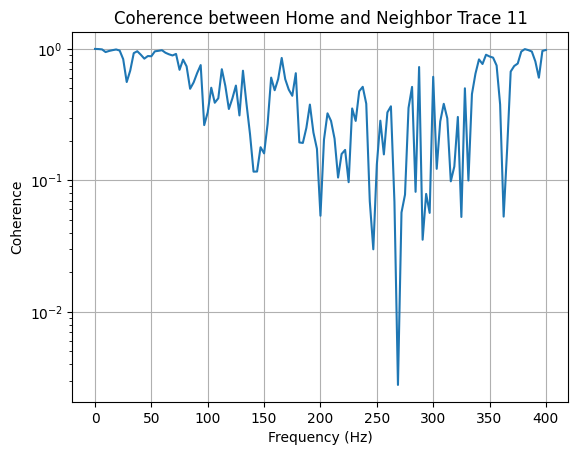

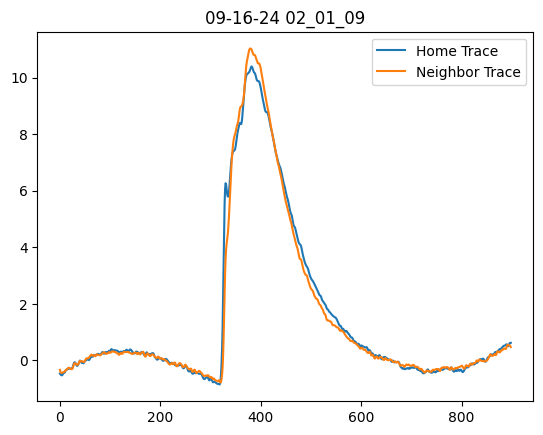

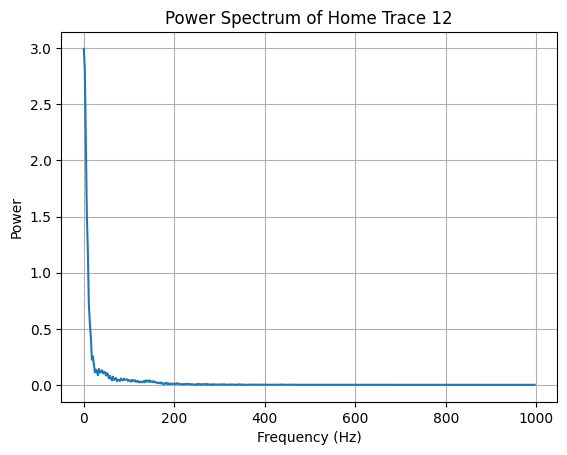

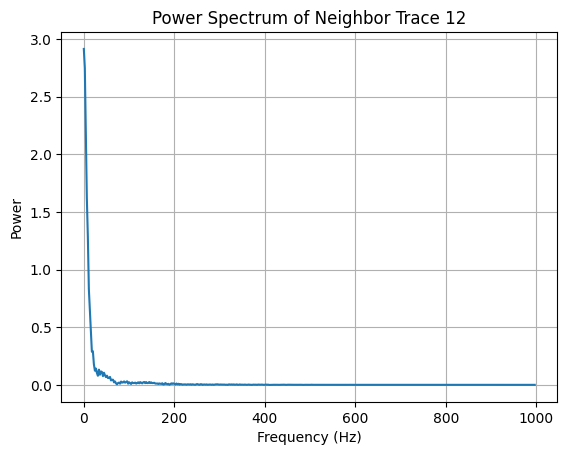

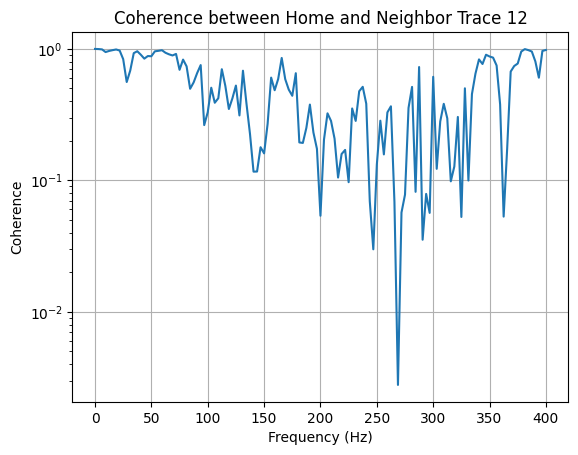

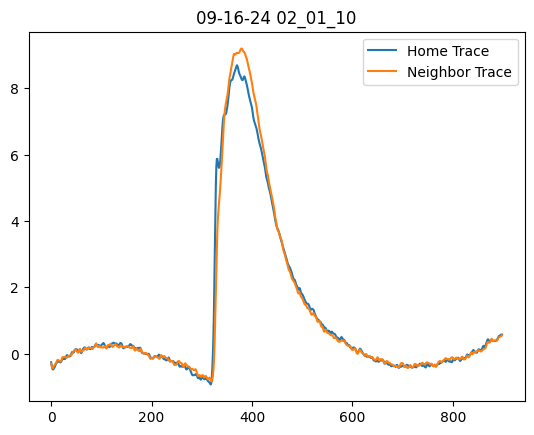

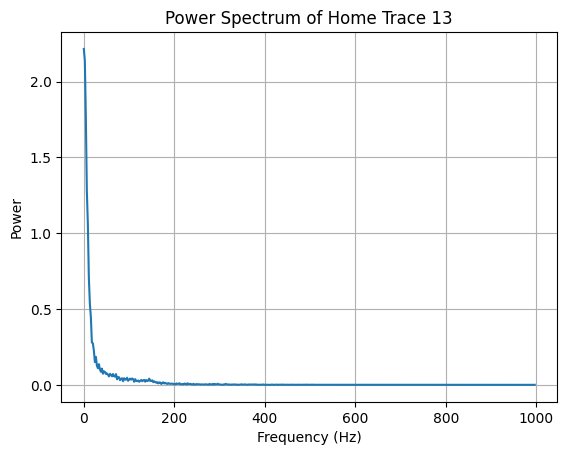

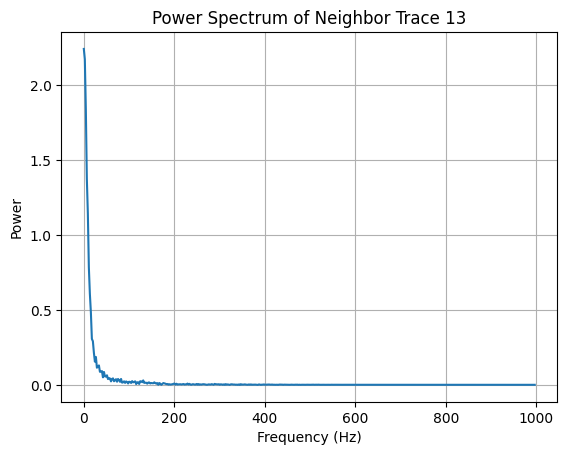

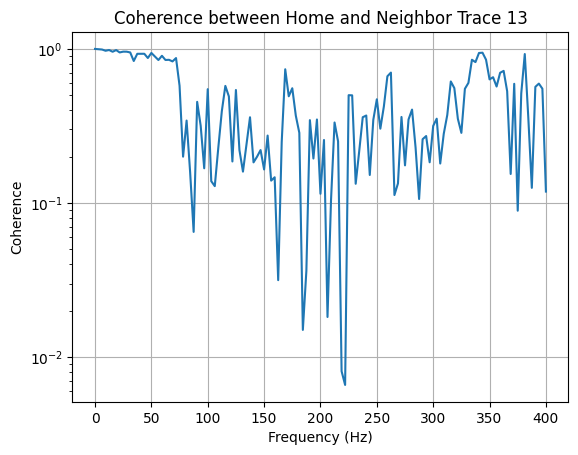

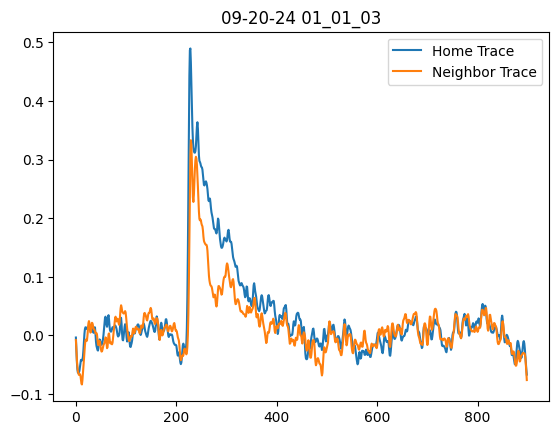

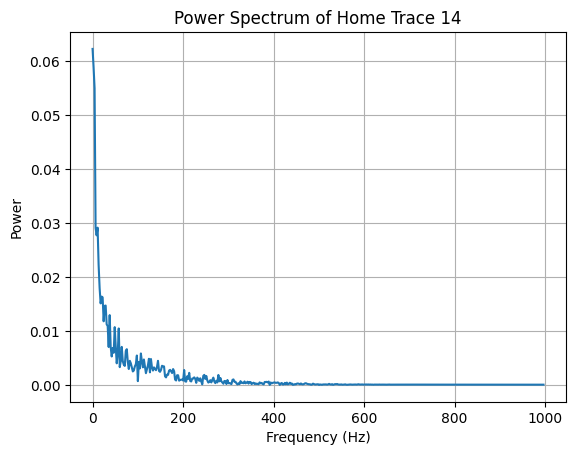

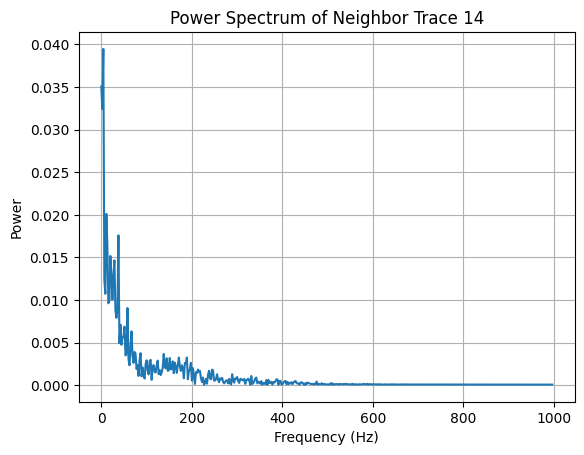

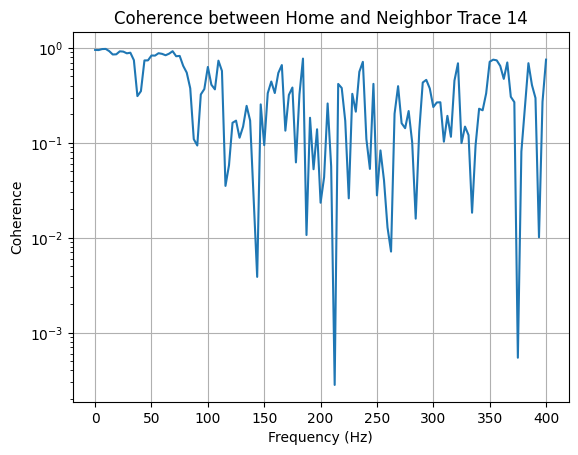

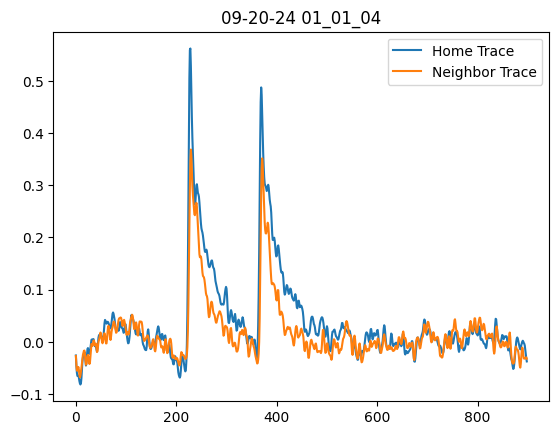

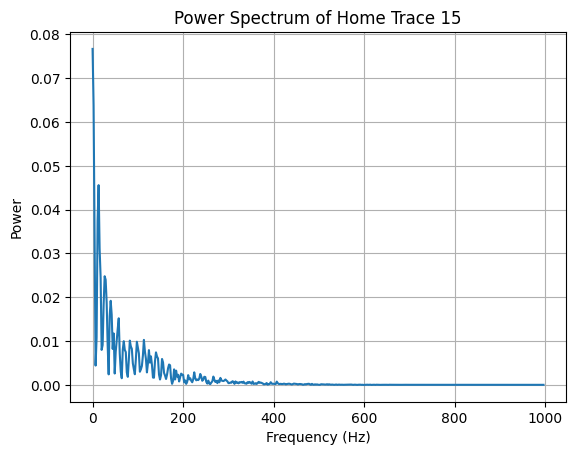

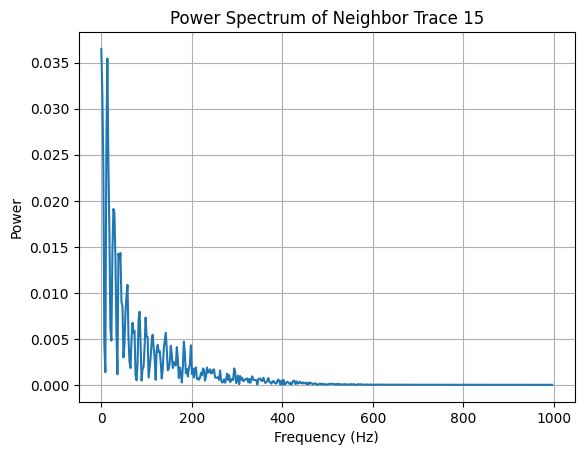

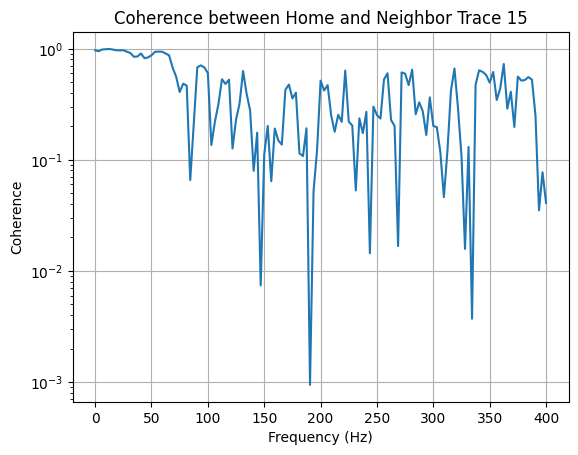

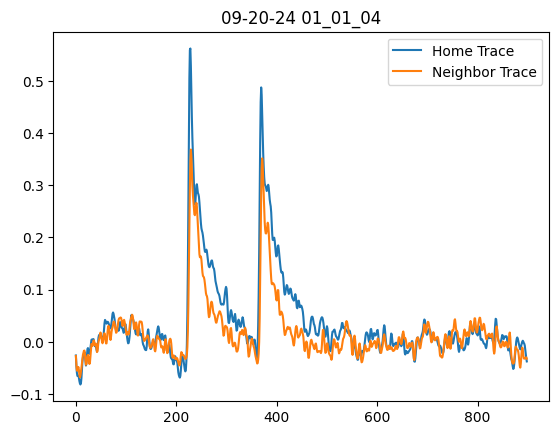

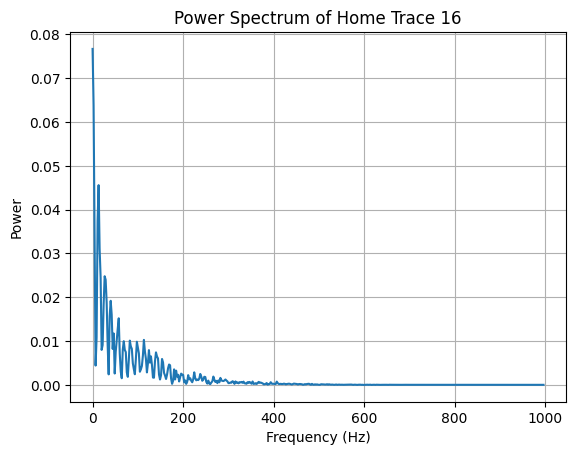

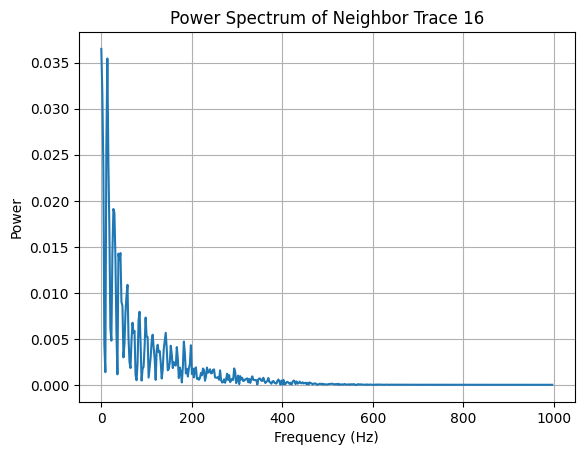

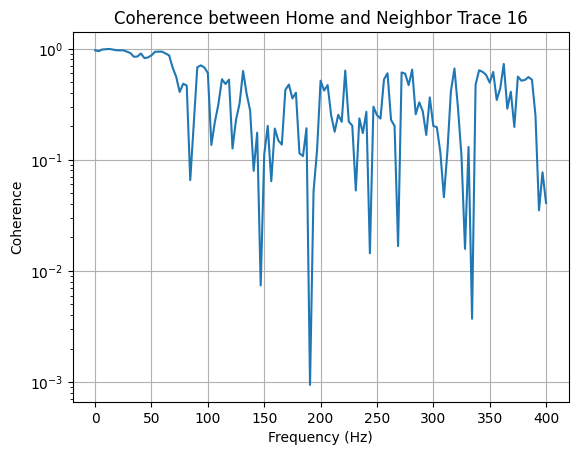

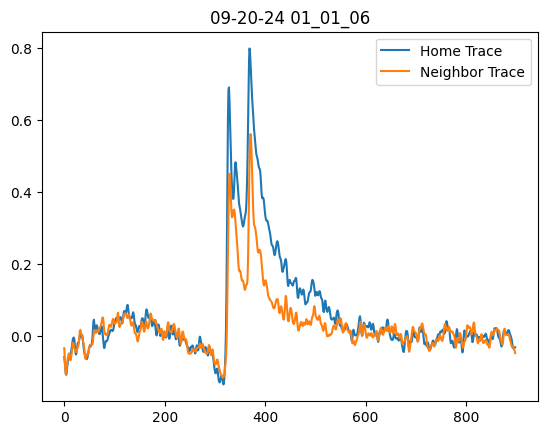

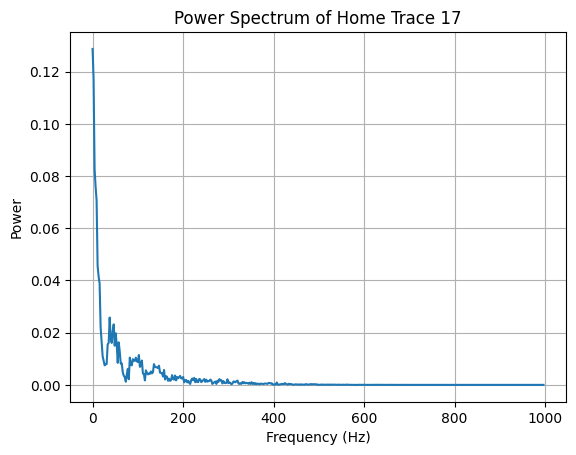

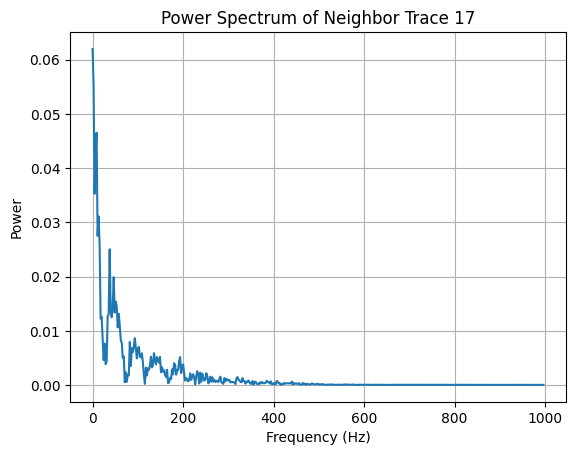

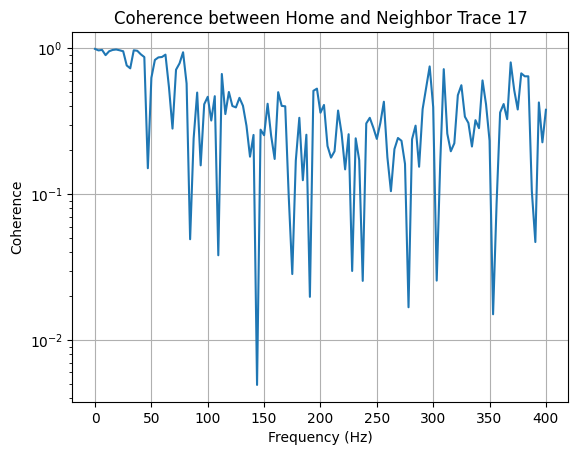

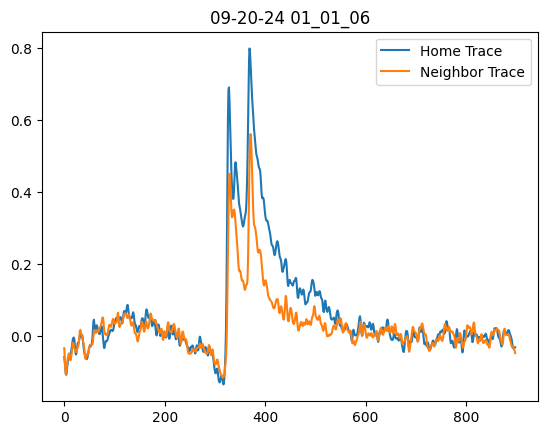

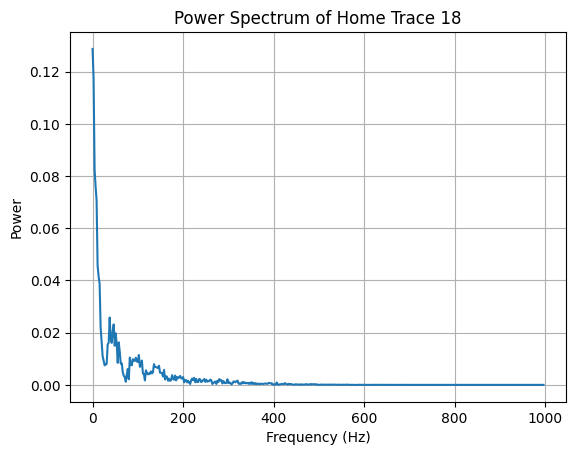

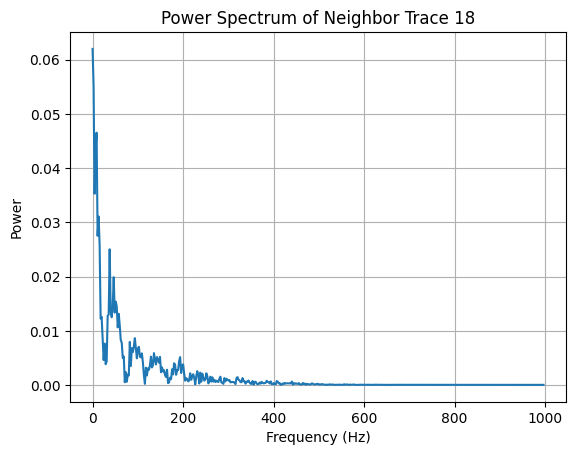

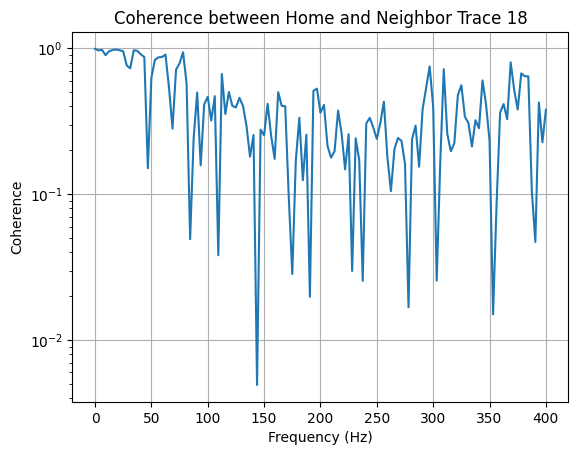

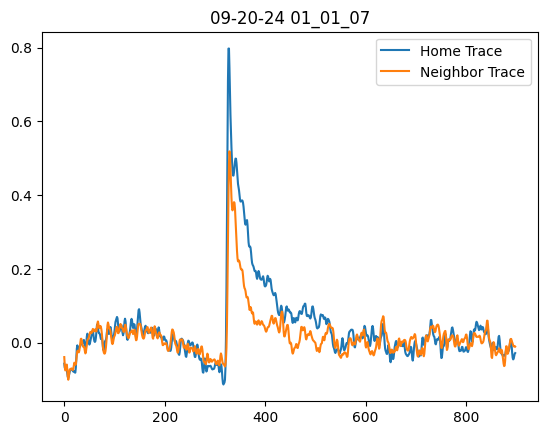

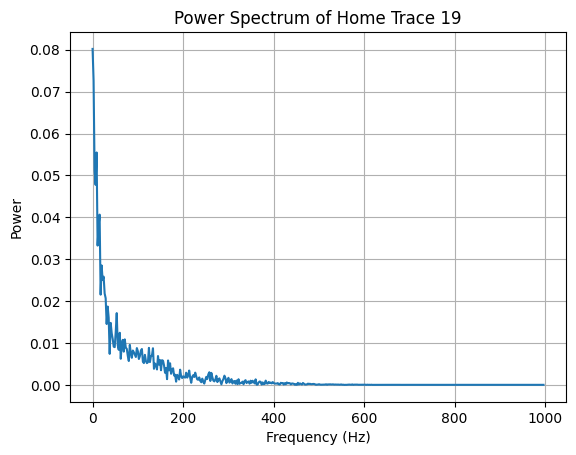

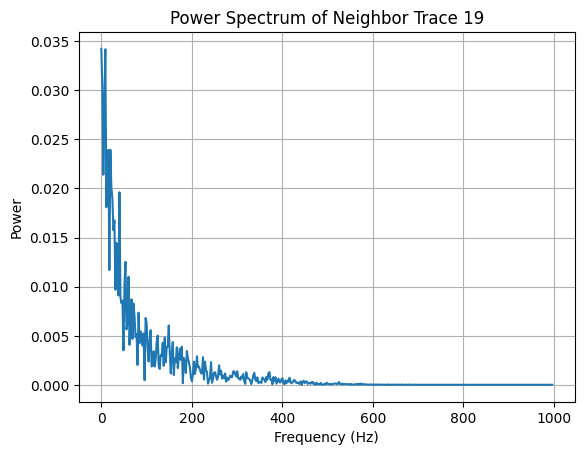

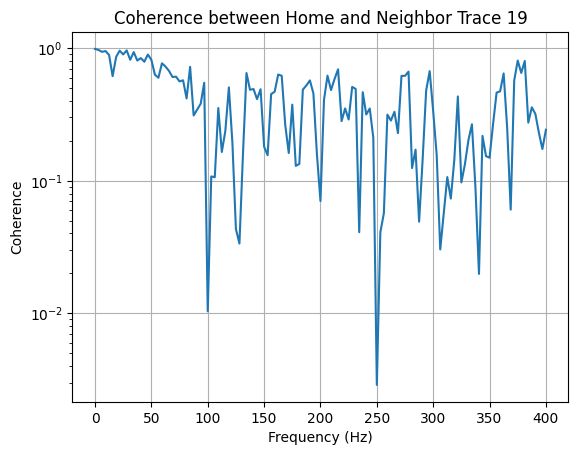

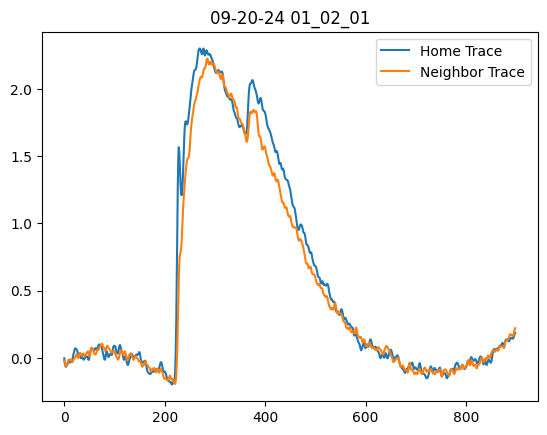

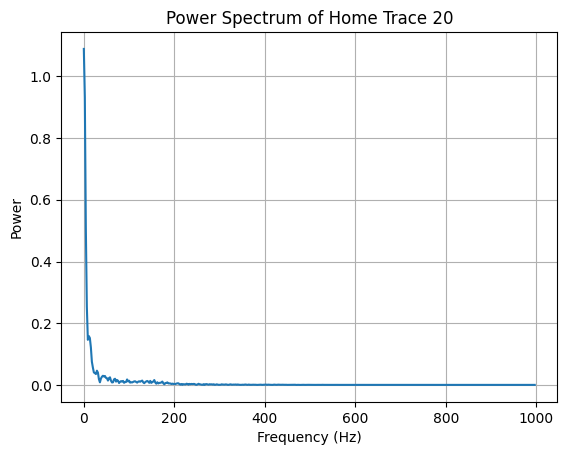

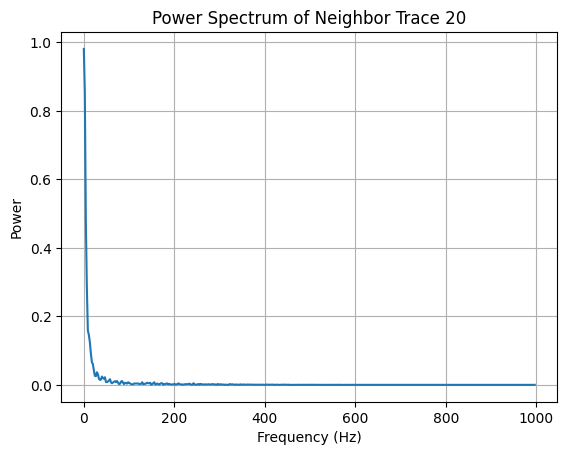

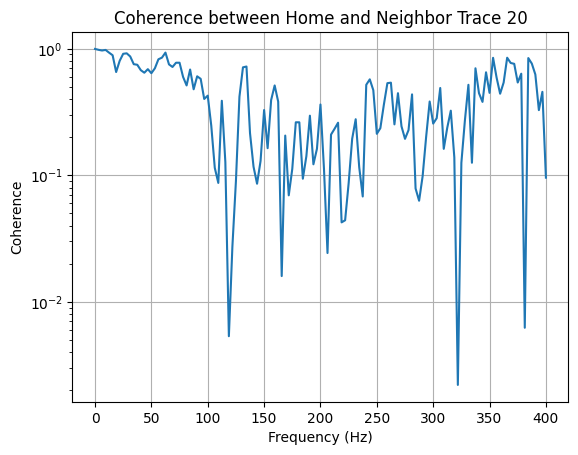

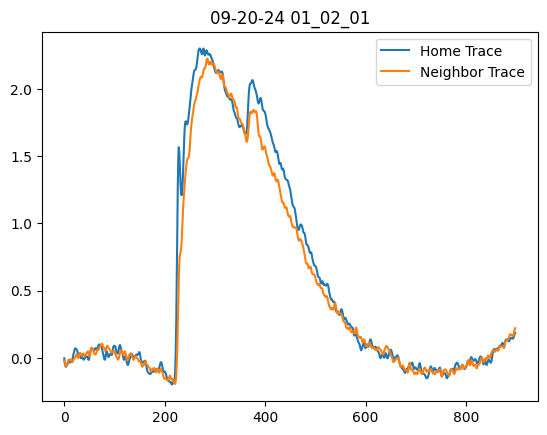

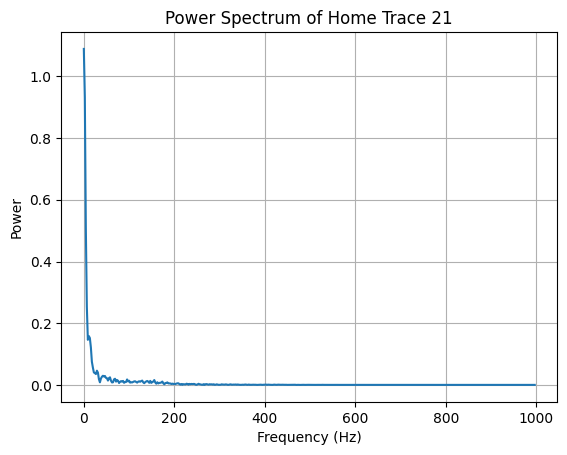

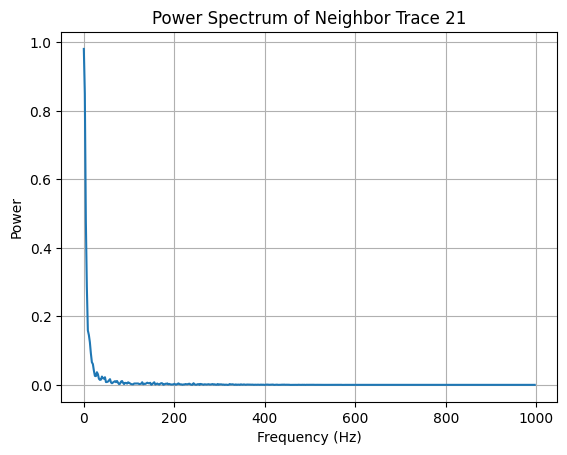

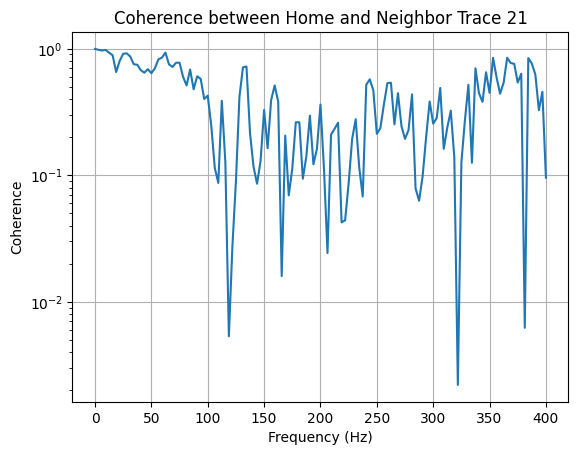

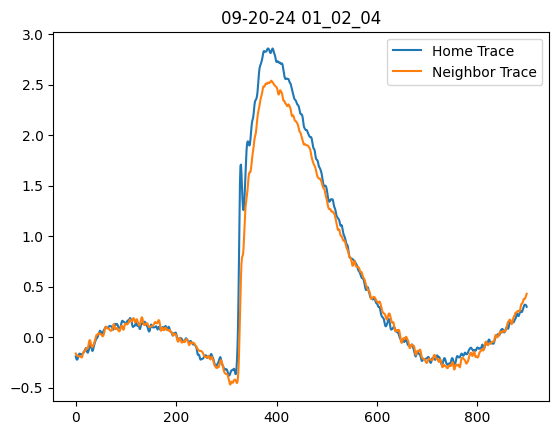

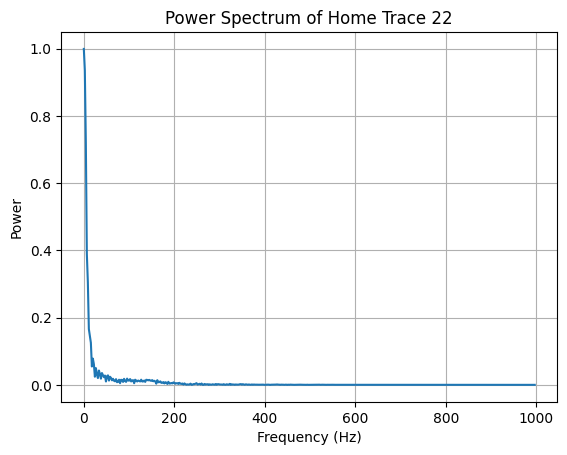

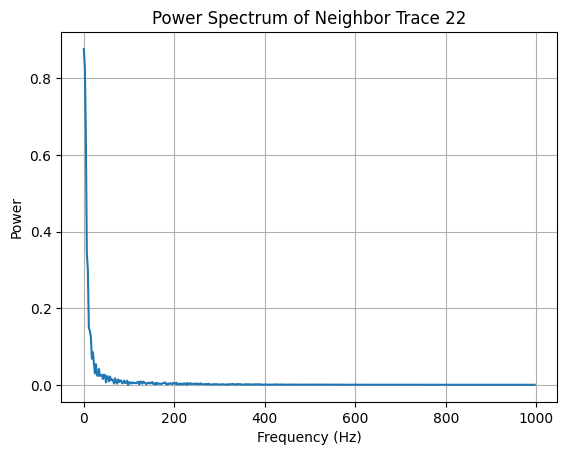

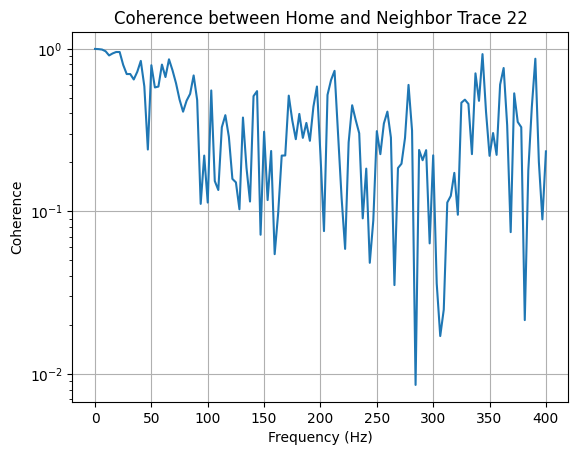

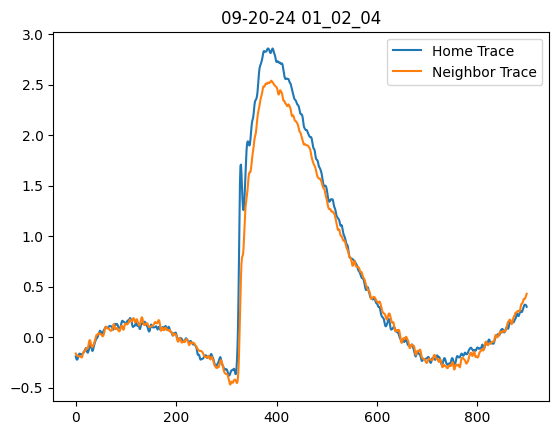

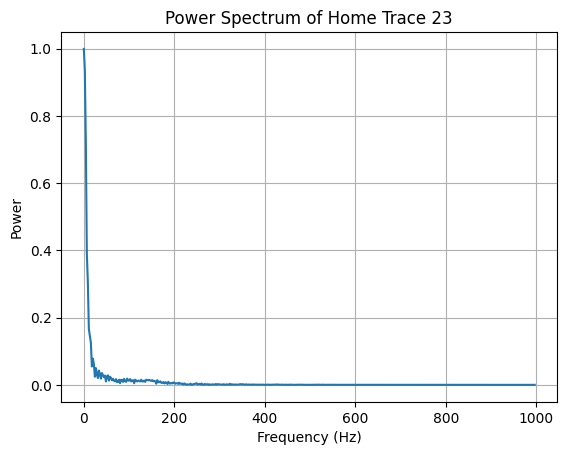

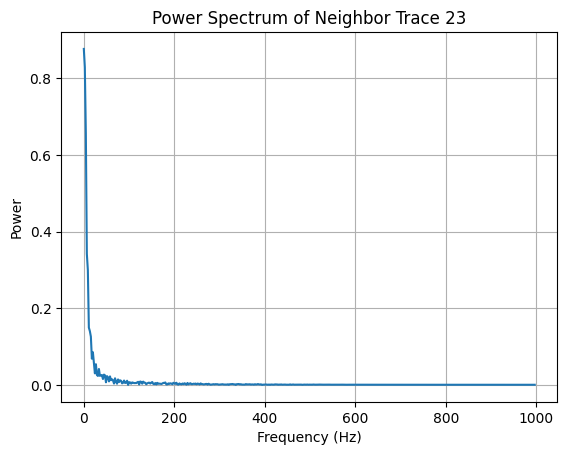

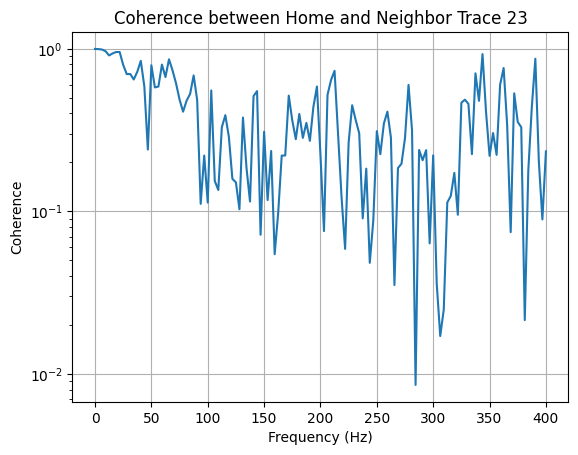

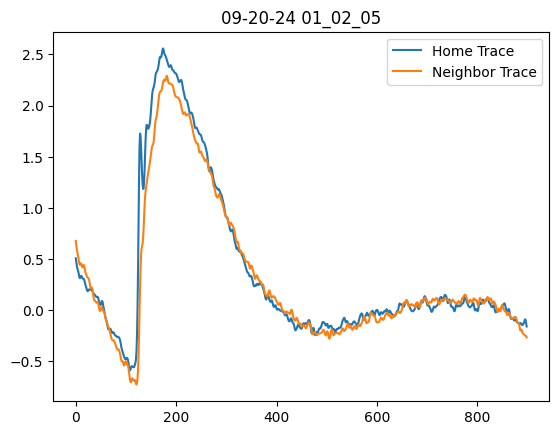

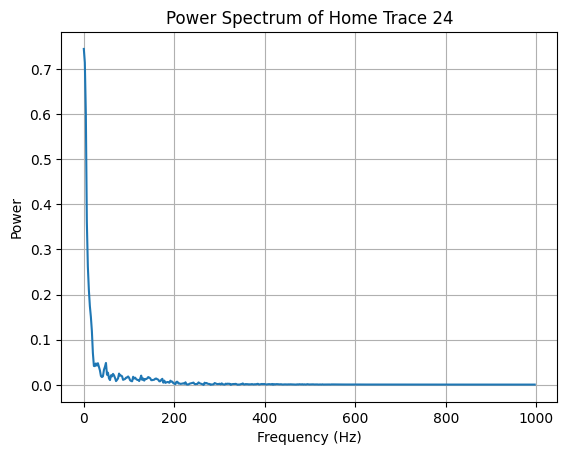

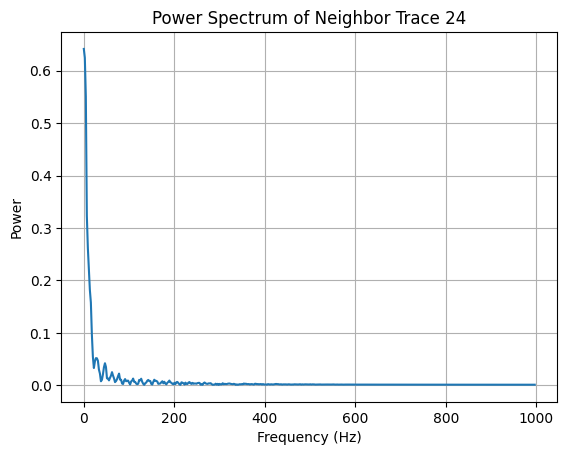

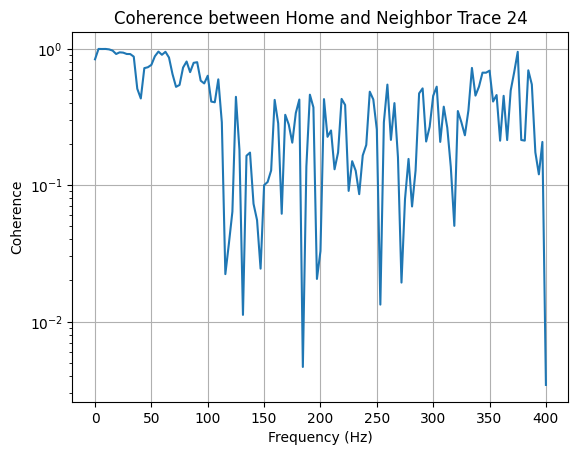

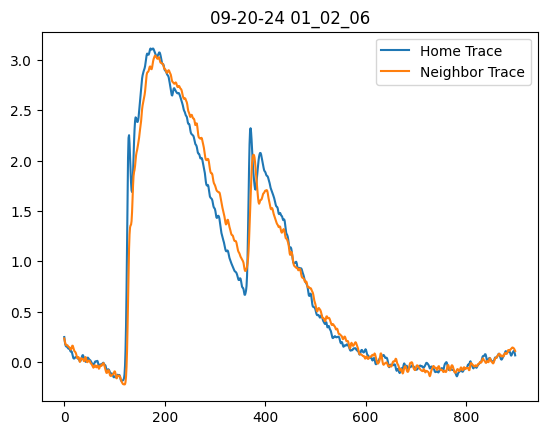

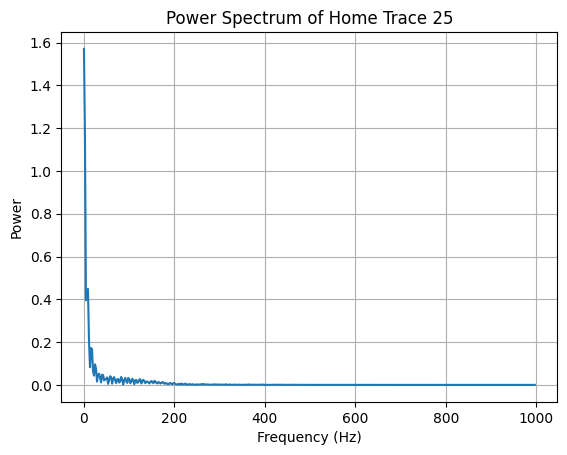

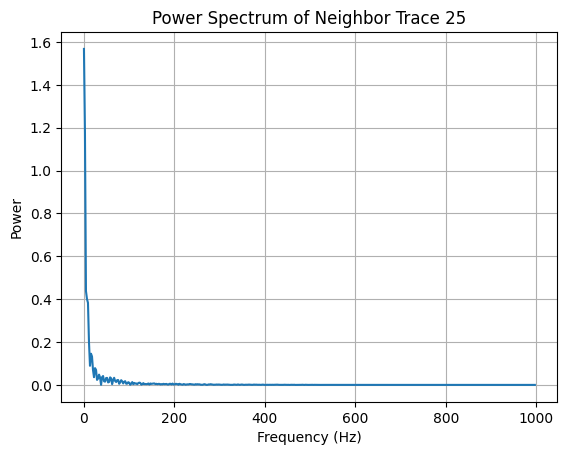

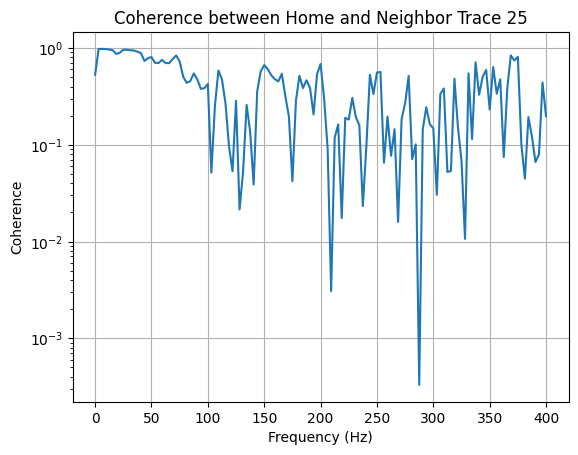

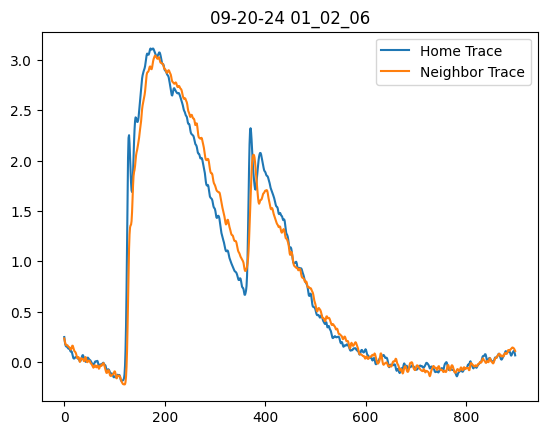

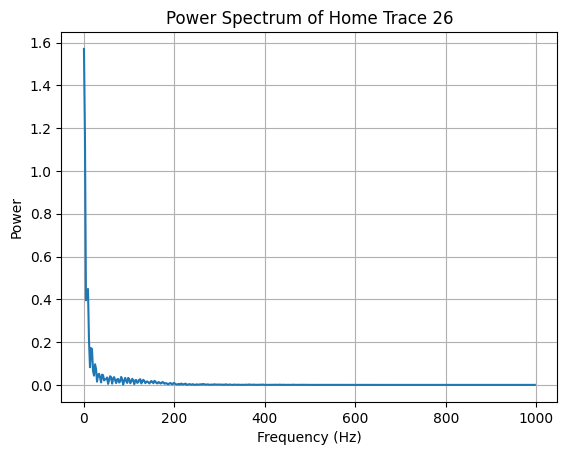

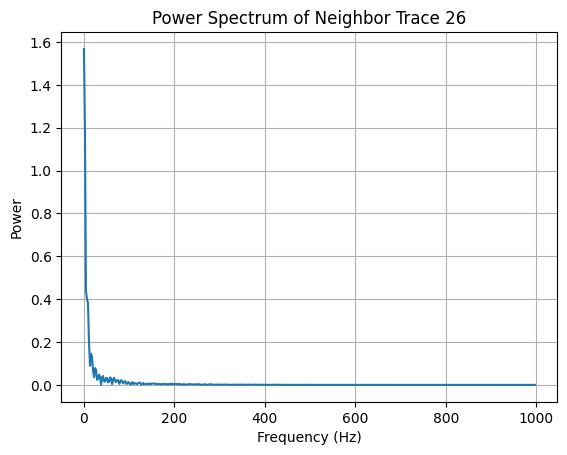

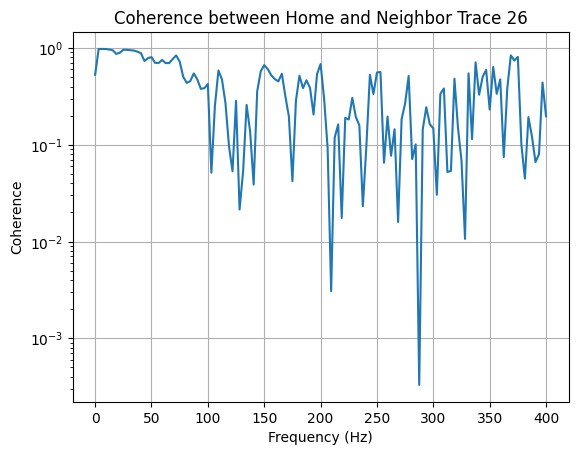

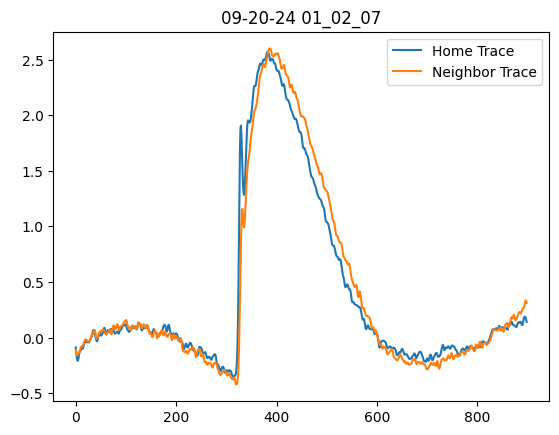

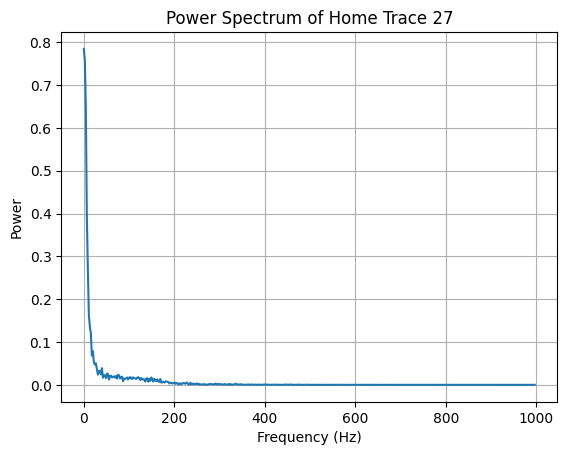

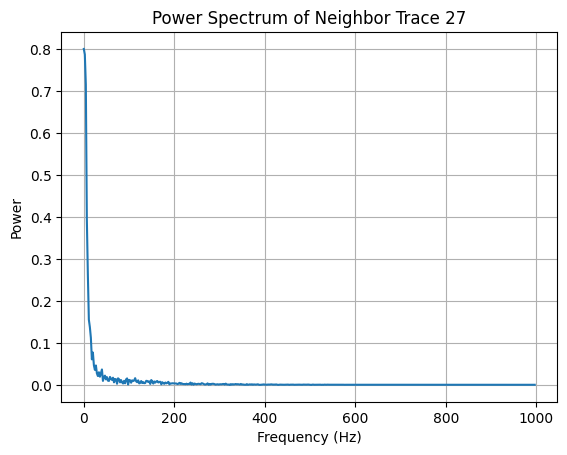

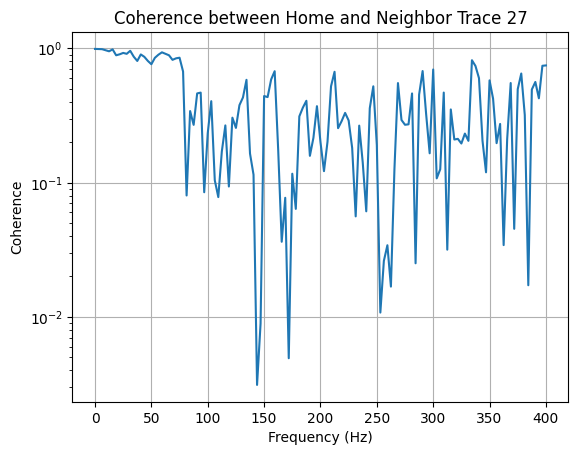

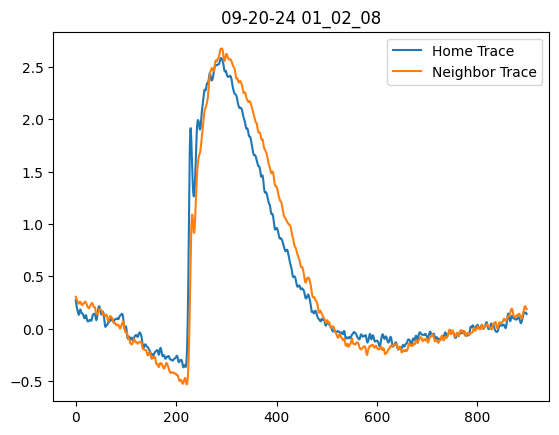

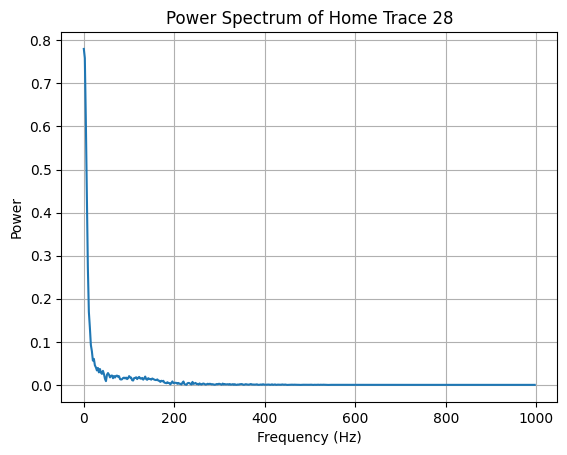

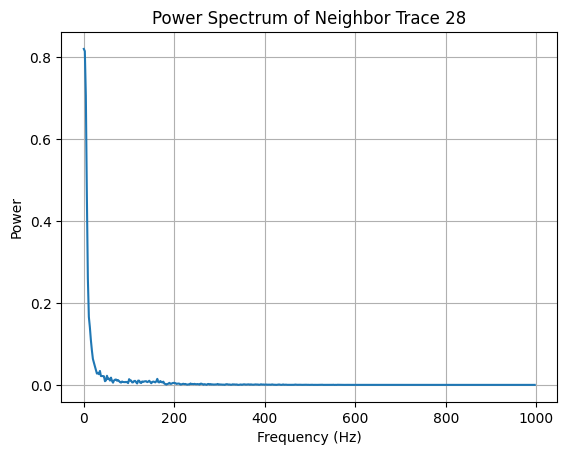

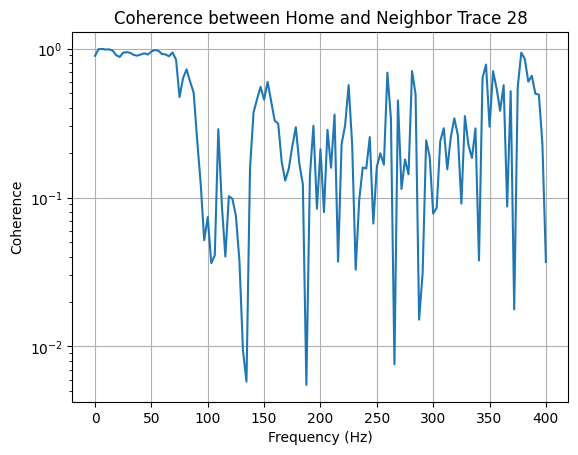

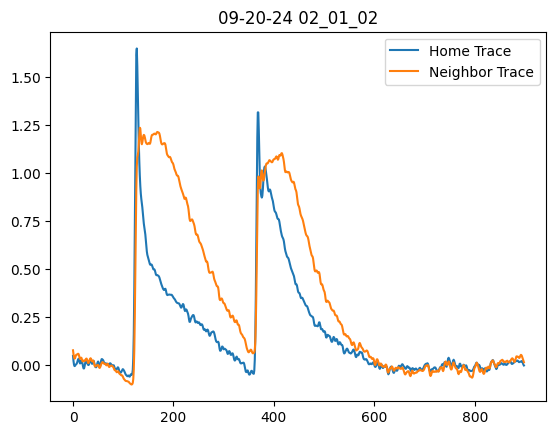

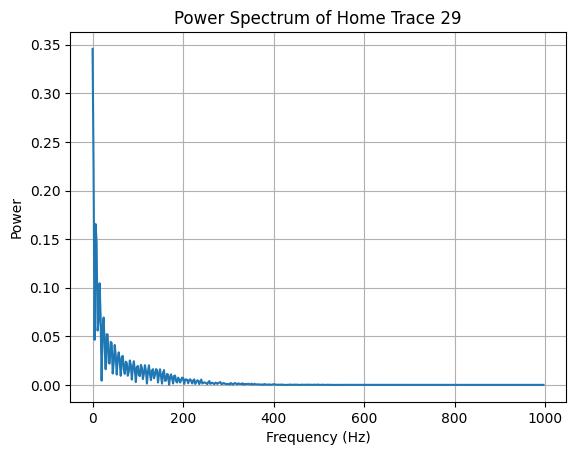

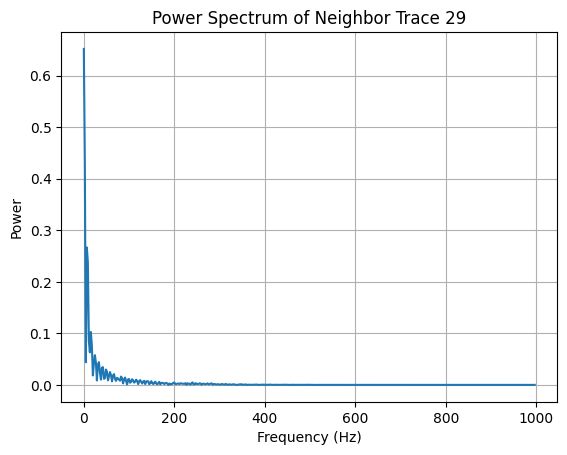

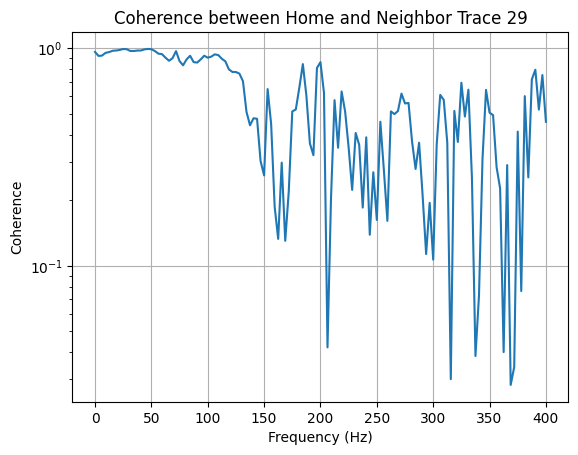

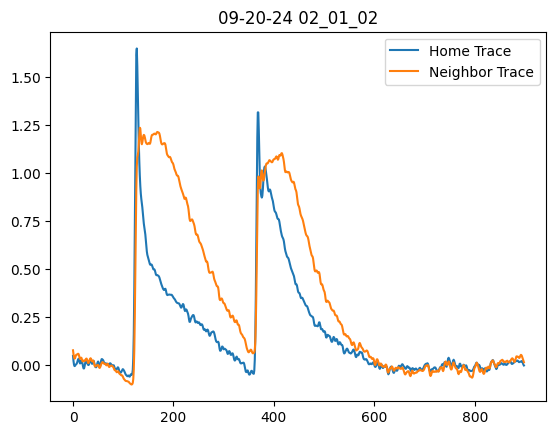

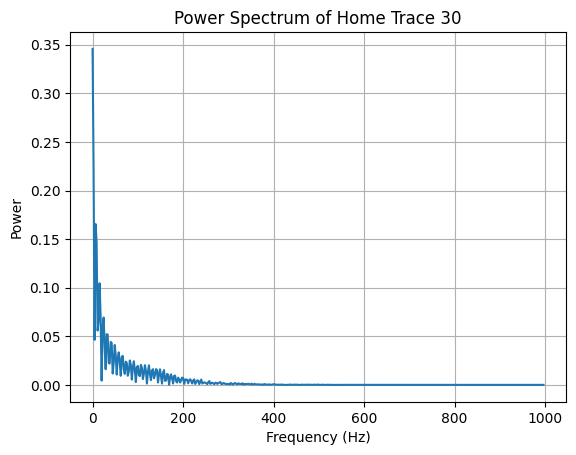

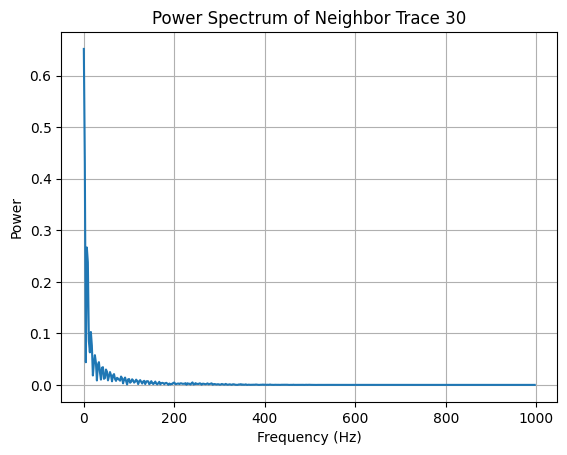

In [17]:
# read in the traces again. Now apply FFT and plot the power spectrum
# also calculate cross-correlation between the home and neighbor barrel traces (using scipy.signal.coherence)
# and plot the coherence

traces = export_df[export_df['ROI'] == 1]
home_traces = [read_dat_trace_file(trace)["ROI1"].values for trace in traces['trace']]
neighbor_traces = [read_dat_trace_file(trace)["ROI2"].values for trace in traces['trace']]

# get date and zda_id for each trace
dates = [format_date(date) for date in traces['Date']]
zda_ids = [format_zda(slic, loc, rec) for slic, loc, rec in zip(traces['Slice'], traces['Location'], traces['Recording'])]

def plot_power_spectrum(trace, title):
    # Apply FFT
    N = len(trace)
    T = 0.5 / 1000  # in seconds -- Sample spacing
    yf = fft(trace)
    xf = np.fft.fftfreq(N, T)[:N//2]

    # Plot power spectrum
    plt.figure()
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.xlim(0, 300) 
    plt.grid()
    plt.show()

def plot_coherence(home_trace, neighbor_trace, title):
    # Calculate coherence
    f, Cxy = coherence(home_trace, neighbor_trace, fs=800)  # Adjust fs as needed

    # Plot coherence
    plt.figure()
    plt.semilogy(f, Cxy)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Coherence')
    plt.grid()
    plt.show()

# Loop over the traces in export_df
for idx, (home_trace, neighbor_trace) in enumerate(zip(home_traces, neighbor_traces)):

    # plot home and neighbor traces
    plt.figure()
    plt.plot(home_trace, label='Home Trace')
    plt.plot(neighbor_trace, label='Neighbor Trace')
    
    plt.title(dates[idx] + ' ' + zda_ids[idx])
    plt.legend()
    plt.show()

    # Plot power spectrum for home trace
    plot_power_spectrum(home_trace, f'Power Spectrum of Home Trace {idx+1}')
    
    # Plot power spectrum for neighbor trace
    plot_power_spectrum(neighbor_trace, f'Power Spectrum of Neighbor Trace {idx+1}')
    
    # Plot coherence between home and neighbor traces
    plot_coherence(home_trace, neighbor_trace, f'Coherence between Home and Neighbor Trace {idx+1}')